In [690]:
%matplotlib inline

In [1423]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.constants
from scipy.integrate import quad, simps, trapz
from scipy.optimize import brentq

In [318]:
kB = scipy.constants.k

In [2391]:
num_row = 41
f_MCE = 50.e6
T_MCE = 1./f_MCE
T_row = 100*T_MCE
T_tot = num_row*T_row
1./T_tot

12195.121951219511

# Noise Computation

In [1994]:
class Noise(object):
    def __init__(self, names, stds):
        self.names = names
        try:
            self.stds = stds
            self.vars = [v*v for v in stds]
        except TypeError:
            self.stds = [stds]
            self.vars = [stds*stds]
        self.total = np.sqrt(np.sum(np.array(self.vars)))

    def add_stage(self, gain=1., newnames=[], newstds=[]):
        names = self.names + newnames
        values = [gain*v for v in self.stds] + newstds
        return Noise(names, values)
    
    def __add__(self, other):
        names = self.names + other.names
        stds = self.stds + other.stds
        return Noise(names, stds)
    
    def __mul__(self, other):
        names = self.names
        stds = [other*v for v in self.stds]
        return Noise(names, stds)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        printstr = "{0:>20} {1:<20}"
        toret = ''
        toret += printstr.format('Source', 'Std Dev (nV/sqrt(Hz))') + '\n'
        toret += printstr.format('-'*18, '-'*18) + '\n'
        for i in range(len(self.names)):
            name = self.names[i]
            std = self.stds[i]
            toret += printstr.format(name, std*1.e9) + '\n'
        toret += printstr.format('-'*20, '-'*20) + '\n'
        toret += printstr.format('TOTAL', np.sqrt(np.sum(self.vars))*1.e9)
        return toret
    
    def __repr__(self):
        return self.__str__()
            
def parallel(*args):
    a = np.array(args)
    a = 1./a
    a = np.sum(a)
    return 1./a

In [1995]:
# ADR444 = Voltage Reference
dV_ADR444 = 78.6e-9  # 78.6 nV/sqrt(Hz)

# OPA2277 = General purpose op amp
dV_OPA2277 = 12.e-9  # 8 nV/sqrt(Hz) @ 10 Hz. Use this over @ 1 kHz value since f_SUM ~ 30 Hz
dI_OPA2277 = 0.2e-12 # 0.2 pA/sqrt(Hz)

# AD8221 = TRead_Standard InAmp, AD620 = old TRead_Standard InAmp
dV_AD620 = 10.e-9    # 9 nV/sqrt(Hz)
dV_AD8221 = 8.e-9    # 8 nV/sqrt(Hz)
dV_AD8221 = dV_AD620  #DELME for comparing against data with old InAmp
# dI_AD8221 = see cell below
dVout_AD620 = 72.e-9  # 72 nV/sqrt(Hz) @ 1 kHz, no curve supplied.
# dVout_AD8221 = 75.e-9  # 75 nV/sqrt(Hz) @ 1 kHz, no curve supplied.
dVout_AD8221 = dVout_AD620  #DELME for comparing against data with old InAmp

# AD8429 = TRead_LR InAmp
dV_AD8429 = 1.e-9    # 1 nV/sqrt(Hz)
# dI_AD8429 = see cell below
dVout_AD8429 = 45.e-9  # 45 nV/sqrt(Hz) @ 1 kHz, no curve supplied.
# AD8429 data sheet supplies RTI voltage noise curve, could make better estimate

T_room = 293.15      # Room temperature ~ 20 degC
T = T_room # 1.               # test device temperature ~ 1 K

# AD7685 = ADC
dD_AD7685 = 0.55      # 0.6 LSB = counts (0.55 measured?)

In [1996]:
# AD8221 equivalent white current noise

# Model current noise w/ 1/f knee
fs = np.array([2., 200.])
dI0 = 40.e-15
dIs = np.array([400., 50.])*1.e-15 - dI0
logfs = np.log(fs)
logdIs = np.log(dIs)
alpha, beta = np.polyfit(logfs, logdIs, 1)
A = np.exp(beta)
n = alpha
dI_func = lambda f: A*(f**n) + dI0

# Demodulation filter function |H(w)|^2
# filt_func = lambda w: np.sin(w*t_SUM/2.)**2 * np.cos(w*t0/2.)**2/((w*t_SUM/2.)**2)
filt_func = lambda w: np.sin(w*t_SUM/2.)**2 * np.sin(w*t0/2.)**2/((w*t_SUM/2.)**2)

# Integrate current noise density \int_0^\infty |H(\omega)|^2 \delta I(\omega)^2 \dd \omega
h2f = lambda f: filt_func(2*np.pi*f) * dI_func(f)**2
dI_AD8221 = np.sqrt(quad(h2f, 0, np.infty, limit=500)[0]/f_filt) # Divide by effective bandwidth and sqrt to get units right
print "dI_AD8221 = {0} fA/sqrt(Hz)".format(dI_AD8221*1.e15)

dI_AD8221 = 120.906349872 fA/sqrt(Hz)


In [1997]:
# AD8429 equivalent white current noise

# Model current noise w/ 1/f knee
fs = np.array([2., 200.])
dI0 = 1.5e-12
dIs = np.array([11., 2.])*1.e-12 - dI0
logfs = np.log(fs)
logdIs = np.log(dIs)
alpha, beta = np.polyfit(logfs, logdIs, 1)
A = np.exp(beta)
n = alpha
dI_func = lambda f: A*(f**n) + dI0

# Demodulation filter function |H(w)|^2
# filt_func = lambda w: np.sin(w*t_SUM/2.)**2 * np.cos(w*t0/2.)**2/((w*t_SUM/2.)**2)
filt_func = lambda w: np.sin(w*t_SUM/2.)**2 * np.sin(w*t0/2.)**2/((w*t_SUM/2.)**2)

# Integrate current noise density \int_0^\infty |H(\omega)|^2 \delta I(\omega)^2 \dd \omega
h2f = lambda f: filt_func(2*np.pi*f) * dI_func(f)**2
dI_AD8429 = np.sqrt(quad(h2f, 0, np.infty, limit=500)[0]/f_filt) # Divide by effective bandwidth and sqrt to get units right
print "dI_AD8429 = {0} pA/sqrt(Hz)".format(dI_AD8429*1.e12)

dI_AD8429 = 4.14995478054 pA/sqrt(Hz)


In [1998]:
# AD620 equivalent white voltage noise

# Model current noise w/ 1/f knee
fs = np.array([1., 10.])
dV0 = 9.e-9
dVs = np.array([21., 10.])*1.e-9 - dV0
logfs = np.log(fs)
logdVs = np.log(dVs)
alpha, beta = np.polyfit(logfs, logdVs, 1)
A = np.exp(beta)
n = alpha
dV_func = lambda f: A* (f**n) + dV0

# Demodulation filter function |H(w)|^2
# filt_func = lambda w: np.sin(w*t_SUM/2.)**2 * np.cos(w*t0/2.)**2/((w*t_SUM/2.)**2)
filt_func = lambda w: np.sin(w*t_SUM/2.)**2 * np.sin(w*t0/2.)**2/((w*t_SUM/2.)**2)

# Integrate current noise density \int_0^\infty |H(\omega)|^2 \delta I(\omega)^2 \dd \omega
h2f = lambda f: filt_func(2*np.pi*f)* dV_func(f)**2
dV_AD620 = np.sqrt(quad(h2f, 0, np.inf, limit=500)[0]/f_filt) # Divide by effective bandwidth and sqrt to get units right
print "dV_AD620 = {0} nV/sqrt(Hz)".format(dV_AD620*1.e9)
dV_AD8221 = dV_AD620  # re-assign our voltage noise to use the old amplifier value

dV_AD620 = 9.81343487856 nV/sqrt(Hz)


In [2003]:
# PIPER laboratory parameters
fs = 4.e3  # 4 kHz sampling rate
N_SUM = 66 # SUM_TICKS = 66
N_GAP = 59
t_SUM = N_SUM/fs
f_SUM = 1./(2*t_SUM)
t_GAP = N_GAP/fs
# t0 = 3./2.*t_SUM + N_GAP/fs
t0 = t_SUM + t_GAP
t_SUM, f_SUM, t0

(0.0165, 30.3030303030303, 0.03125)

## TRead_Standard

In [2788]:
# TRead_Standard
R_45 = 20.e3   # 20 kOhm
R_47 = 20.e3   # 20 kOhm
R_50 = 49.9e3  # 49.9 kOhm
R_52 = 698.    # 698 Ohms
R_ADG419 = 45. # 45 Ohms for +-15 V, +5V biased
G_ref = R_52/(R_50 + R_52)  # divider gain
V_ref = 4.096  # 4.096 V voltage reference
deltaV = 4*V_ref
R_FB = 7.e3    # 7 kOhm
# G_dac = 64./513.      # MDAC gain, for 64 nA
# ADAC = G_dac*(2**16)
G_pre = 100.
# G = 16.
R_P = 100. + 680.     # DG407DJ mux resistance + protection resistor
R_L = 10.e3 + 100.e3  # protection resistor + bias resistor
R_T = 10.e3    # 10 kOhm
R_m1 = 20.e3   # 20 kOhm

ADACs = adac_unique
G_dacs = ADACs/2**16
Gs = gain_unique

R_Ts = np.logspace(0, 6, 50)  # 1 Ohm -> 1 MOhm
dV_Gs = []
dRT_Gs = []
dDemod_Gs = []

for G_dac in G_dacs:
    ADAC = G_dac*(2**16)
    dvs1 = []
    drts1 = []
    dds1 = []
    for G in Gs:
        dvs2 = []
        drts2 = []
        dds2 = []
        
        # A
        names = ['U14']
        stds = [dV_ADR444]
        dV_A = Noise(names, stds)
        #dV_A

        # B
        names = ['U15B_V', 'U15B_I', 'U15B_R']
        stds = [2*dV_OPA2277, R_45*dI_OPA2277, np.sqrt(4*kB*T_room*(R_45 + R_47))]
        dV_B = dV_A.add_stage(1., names, stds)
        # dV_B

        # C
        names = ['divider_R']
        stds = [np.sqrt(4*kB*T_room*parallel(R_52, R_50 + R_ADG419))]
        dV_C = dV_B.add_stage(G_ref, names, stds)
        #dV_C

        # IN
        names = ['U15A_V', 'U15A_I']
        stds = [dV_OPA2277, parallel(R_52, R_50 + R_ADG419)*dI_OPA2277]
        dV_in = dV_C.add_stage(1., names, stds)
        #dV_in

        # DAC
        names = ['U18A_V', 'U18A_I', 'DAC_FB_R']
        stds = [2*dV_OPA2277, R_FB*dI_OPA2277, np.sqrt(4*kB*T_room*R_FB)]
        dV_DAC = dV_in.add_stage(G_dac, names, stds)
        #dV_DAC

        # Bias circuit
        dV_m1 = Noise(['U18B_V', 'U18B_I', 'U18B_R'], [2*dV_OPA2277, R_m1*dI_OPA2277, np.sqrt(4*kB*T_room*2*R_m1)])
        dV_RL = Noise(['Johnson_RL'], np.sqrt(4*kB*T_room*R_L))
        dV_amp = Noise(['InAmp_V'], dV_AD8221)
        dV_ampout = Noise(['InAmp_out'], [dVout_AD8221])
        dI_inamp = Noise(['InAmp_I'], [dI_AD8221])

        # ADC Noise back-referenced to ADC input
        dV_ADC = Noise(['ADC'], (20.48/65535.) * dD_AD7685/np.sqrt(2000.))
        #dV_ADC

        for R_T in R_Ts:
            dV_RT = Noise(['Johnson_RT'], np.sqrt(4*kB*T*R_T))
            g1 = G_pre*(2*R_L/(2*R_L + R_T))
            g2 = G_pre*(R_T/(2*R_L + R_T))
            g3 = np.sqrt(2)*G_pre*(R_P + 0.5*(2*R_L*R_T)/(2*R_L + R_T))
            dV_G = (G*(dV_ampout
                       + G_pre*dV_amp
                       + g1*dV_RT
                       + g2*(np.sqrt(2)*dV_DAC + dV_m1 + np.sqrt(2)*dV_RL)
                       + g3*dI_inamp)
                   + dV_ADC)
            dvs2.append(dV_G)

            alpha = 2*G*G_pre*G_ref*G_dac*V_ref
#             V_ref = 4.096  # Volts
            V_G = G*G_pre*(G_dac*G_ref*V_ref) * 2/(1 + 2*R_L/R_T)
            drtg = 2.*R_L*alpha*ADAC*deltaV/(alpha*ADAC - V_G)**2 * dV_G
            drts2.append(drtg)

            beta = 2**16/20.48*2*N_SUM
            ddg = beta*dV_G
            dds2.append(ddg)
        dvs1.append(dvs2)
        drts1.append(drts2)
        dds1.append(dds2)
    dV_Gs.append(dvs1)
    dRT_Gs.append(drts1)
    dDemod_Gs.append(dds1)

In [2789]:
# ADC-input referred voltages (V_G)
# Collate individual components for various R_T values
dV_Gs_tot = []
dV_Gs_components = []
for i in range(len(G_dacs)):
    ddgtot1 = []
    ddgc1 = []
    for j in range(len(Gs)):
        ddgtot2 = np.array([dvg.total for dvg in dV_Gs[i][j]])
        ddgtot1.append(ddgtot2)
        ddgc2 = []
        for k in range(len(dV_Gs[i][j][0].names)):
            toadd = np.array([dvg.stds[k] for dvg in dV_Gs[i][j]])
            ddgc2.append(toadd)
        ddgc1.append(ddgc2)
    dV_Gs_tot.append(ddgtot1)
    dV_Gs_components.append(ddgc1)

In [2790]:
# R_T values
# Collate individual components for various R_T values
dRT_Gs_tot = []
dRT_Gs_components = []
for i in range(len(G_dacs)):
    ddgtot1 = []
    ddgc1 = []
    for j in range(len(Gs)):
        ddgtot2 = np.array([dvg.total for dvg in dRT_Gs[i][j]])
        ddgtot1.append(ddgtot2)
        ddgc2 = []
        for k in range(len(dRT_Gs[i][j][0].names)):
            toadd = np.array([dvg.stds[k] for dvg in dRT_Gs[i][j]])
            ddgc2.append(toadd)
        ddgc1.append(ddgc2)
    dRT_Gs_tot.append(ddgtot1)
    dRT_Gs_components.append(ddgc1)

In [2791]:
# Demodulated values
# Collate individual components for various R_T values
dDemod_Gs_tot = []
dDemod_Gs_components = []
for i in range(len(G_dacs)):
    ddgtot1 = []
    ddgc1 = []
    for j in range(len(Gs)):
        ddgtot2 = np.array([dvg.total for dvg in dDemod_Gs[i][j]])
        ddgtot1.append(ddgtot2)
        ddgc2 = []
        for k in range(len(dDemod_Gs[i][j][0].names)):
            toadd = np.array([dvg.stds[k] for dvg in dDemod_Gs[i][j]])
            ddgc2.append(toadd)
        ddgc1.append(ddgc2)
    dDemod_Gs_tot.append(ddgtot1)
    dDemod_Gs_components.append(ddgc1)

In [2792]:
# Integrate filter transfer function to get effective bandwidth
N_sum = 66
N_gap = 59
sign = -1
betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
zfreqs_temp = zfreqs + 0.
freqs, hs = scipy.signal.freqz(betas, worN=zfreqs_temp)
freqs *= 2.e3/np.pi
f_filt = simps(np.abs(hs[freqs < 920])**2, freqs[freqs < 920])

In [2793]:
# Load test data
data = np.loadtxt('imgs/hke_20120103_000_new.txt', skiprows=1, unpack=False)
data_names = ['ch', 'R(nom)', 'ADAC', 'GAIN', 'Demod (avg)', 'Demod (std)', 'NSUM', 'R(avg)', 'R(std)', 'N']
ind = np.lexsort((data[:,3], data[:,2]))
sdata = data[ind]
adac_unique = np.unique(sdata[:,2])
gain_unique = np.unique(sdata[:,3])
sdata_a = [sdata[sdata[:, 2] == a] for a in adac_unique]
sdata_ag = np.array([[s[s[:,3] == g] for g in gain_unique] for s in sdata_a])  # list of list of 2D numpy array
                                                                               # 1st index = adac, 2nd index = gain
# mya = sdata_ag[3, 4, :, (1, 5)]
# plt.plot(mya[0], mya[1], 'o')
# plt.xscale('log')

1st Index (ADAC) =  [  1021.   2043.   4085.   8171.  16341.]
2nd Index (Gain) =  [  1.   2.   4.   8.  16.]
Using: ADAC = 4085.0, Gain = 8.0
Excitation I = 31.9763946533 nA


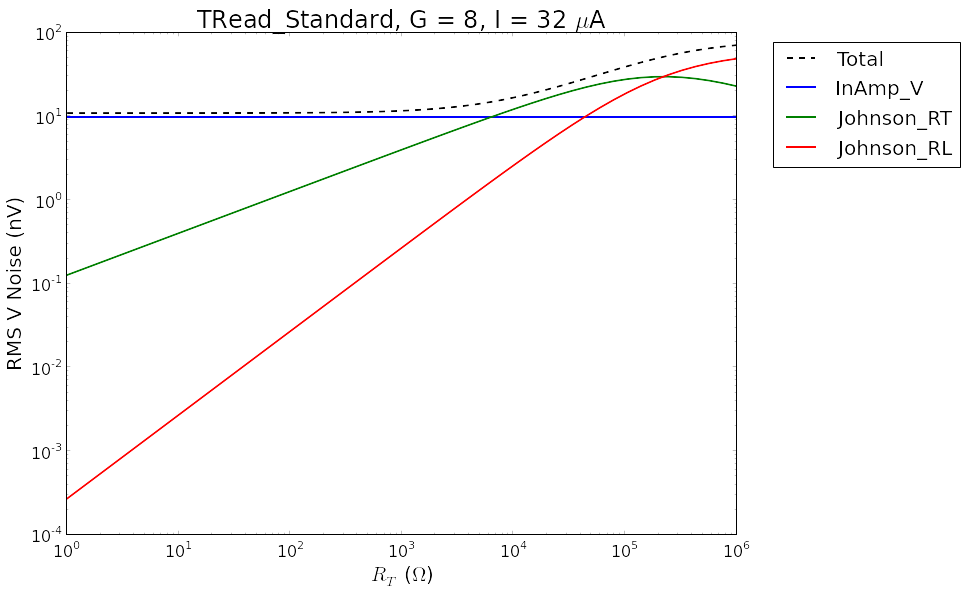

In [2794]:
# ADC-input referred voltage noise
# Plot significant components vs R_T
threshhold = 0.5  # Plot threshhold for individual components, i.e. if ever comp/tot > threshhold, plot it
print "1st Index (ADAC) = ", adac_unique
print "2nd Index (Gain) = ", gain_unique
i = 2
j = 3
print "Using: ADAC = {0}, Gain = {1}".format(adac_unique[i], gain_unique[j])
print "Excitation I = {0} nA".format(G_dacs[i]*513.)

ddgs = dV_Gs[i][j]
ddgt = dV_Gs_tot[i][j]
ddgc = dV_Gs_components[i][j]
# vfact = np.sqrt(f_SUM)*1.e9
vfact = 1.e9/(100*gain_unique[j]) # np.sqrt(1.0736*920.)
fig, ax = plt.subplots(figsize=(12, 9), dpi=150)
ax.plot(R_Ts, ddgt*vfact, 'k--', label='Total', linewidth=2)
for k in range(len(ddgs[0].names)):
    name = ddgs[0].names[k]
    value = ddgc[k]
    if np.any(value/ddgt > threshhold):
        ax.plot(R_Ts, ddgt*0 + value*vfact, label=name, linewidth=2)
        
mya = sdata_ag[i, j, :, (1, 5)]  # 1st -> adac, 2nd -> gain, 3rd -> row, 4th -> column
# col 1 = expected resistance, col 5 = Demod (std)
# ax.plot(mya[0], mya[1], 'o', label='Data')

ax.legend(bbox_to_anchor=(1.35, 1), prop={'size':20})
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$R_T$ ($\Omega$)', fontsize=20)
ax.set_ylabel(r'RMS V Noise (nV)', fontsize=20)
ax.set_title(r'TRead_Standard, G = {0}, I = {1} $\mu$A'.format(int(gain_unique[j]),
                                                               int(np.round(G_dacs[i]*513))), fontsize=24)
# ax.set_ylim(ymin=np.min(dV_Gs_tot)*vfact/10.)
# ax.set_ylim(ymin=1.e-1)
ax.tick_params(labelsize=16)

In [2795]:
print dRT_Gs[0][0][0]
print dRT_Gs[0][0][0].total
print dRT_Gs_tot[0][0]
print np.sqrt(f_filt)

              Source Std Dev (nV/sqrt(Hz))
  ------------------ ------------------  
           InAmp_out 1443748.51762       
             InAmp_V 19677961.1926       
          Johnson_RT 255137.112219       
                 U14 0.217740806532      
              U15B_V 0.0664857424525     
              U15B_I 0.0110809570754     
              U15B_R 0.070495895499      
           divider_R 0.670387290044      
              U15A_V 2.40977478267       
              U15A_I 0.0276473315369     
              U18A_V 309.357492962       
              U18A_I 18.0458537561       
            DAC_FB_R 137.21922832        
              U18B_V 218.748781085       
              U18B_I 36.4581301808       
              U18B_R 231.94282929        
          Johnson_RL 543.95415094        
             InAmp_I 267606.137081       
                 ADC 77066102.3807       
-------------------- --------------------
               TOTAL 79552670.6726       
0.0795526706726
[ 0.07955267  0.0

In [2796]:
print R_T/(2*R_L + R_T), R_T, R_L

0.819672131148 1000000.0 110000.0


In [2797]:
V_in = ADACs/(2**16 - 1) * G_ref * V_ref
G_RT = R_T/(2*R_L + R_T)
V_intoamp = V_in*G_RT
V_intoADC = V_intoamp*G_pre*G

print "Input voltage\n", V_in
print "Voltage into amp\n", V_intoamp
print "Voltage into ADC\n", V_intoADC

print dV_ADC.total/(G_pre*G_dacs)
dRTdVpre = (2*R_L + R_T)**2/(2*R_L*V_in)
print dRTdVpre
print dV_ADC.total/(G_pre*G_dacs) * dRTdVpre

Input voltage
[ 0.00088031  0.00176148  0.00352209  0.00704505  0.01408923]
Voltage into amp
[ 0.00072156  0.00144383  0.00288696  0.00577463  0.01154855]
Voltage into ADC
[  1.15450179   2.31013433   4.61913791   9.23940658  18.4776824 ]
[  2.46693967e-06   1.23286608e-06   6.16583942e-07   3.08254241e-07
   1.54136552e-07]
[  7.68533003e+09   3.84078412e+09   1.92086217e+09   9.60313544e+08
   4.80186155e+08]
[ 18959.24553717   4735.17246959   1184.37276881    296.02072247
     74.0142385 ]


1st Index (ADAC) =  [  1021.   2043.   4085.   8171.  16341.]
2nd Index (Gain) =  [  1.   2.   4.   8.  16.]
Using: ADAC = 1021.0, Gain = 1.0
Excitation I = 7.99214172363 nA


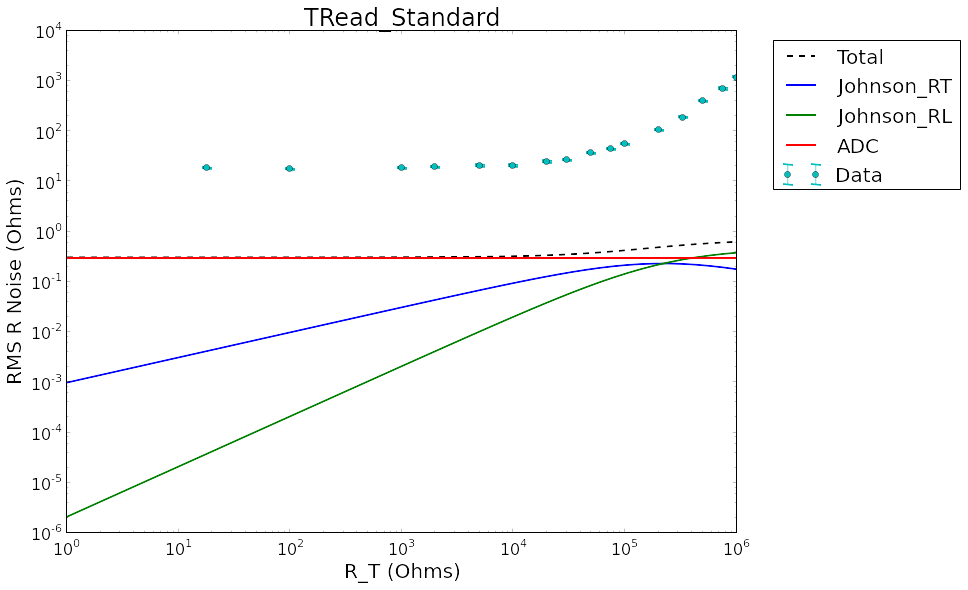

In [2798]:
# R_T referred resistance noise
# Plot significant components vs R_T
threshhold = 0.5  # Plot threshhold for individual components, i.e. if ever comp/tot > threshhold, plot it
print "1st Index (ADAC) = ", adac_unique
print "2nd Index (Gain) = ", gain_unique
i = 0
j = 0
print "Using: ADAC = {0}, Gain = {1}".format(adac_unique[i], gain_unique[j])
print "Excitation I = {0} nA".format(G_dacs[i]*513.)

ddgs = dRT_Gs[i][j]
ddgt = dRT_Gs_tot[i][j]
ddgc = dRT_Gs_components[i][j]
vfact = np.sqrt(f_filt)
fig, ax = plt.subplots(figsize=(12, 9), dpi=150)
ax.plot(R_Ts, ddgt*vfact, 'k--', label='Total', linewidth=2)
for k in range(len(ddgs[0].names)):
    name = ddgs[0].names[k]
    value = ddgc[k]
    if np.any(value/ddgt > threshhold):
        ax.plot(R_Ts, ddgt*0 + value*vfact, label=name, linewidth=2)
        
mya = sdata_ag[i, j, :, (1, 8, 9)]  # 1st -> adac, 2nd -> gain, 3rd -> row, 4th -> column
# col 1 = expected resistance, col 5 = Demod (std)
# ax.plot(mya[0], mya[1], 'o', label='Data')

_, caps, _ = ax.errorbar(mya[0], mya[1], yerr=mya[1]/np.sqrt(2*(mya[2] - 1)), fmt='o', label='Data', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(2)
# ax.plot(mya[0], mya[1], 'o', label='Data')
# ax.plot(mya[0], mya[1]*np.sqrt(2), 'o', label='Data rt2')

ax.legend(bbox_to_anchor=(1.35, 1), prop={'size':20})
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('R_T (Ohms)', fontsize=20)
ax.set_ylabel(r'RMS R Noise (Ohms)', fontsize=20)
ax.set_title('TRead_Standard', fontsize=24)
# ax.set_ylim(ymin=np.min(dV_Gs_tot)*vfact/10.)
# ax.set_ylim(ymin=1.e-1)
ax.tick_params(labelsize=16)

1st Index (ADAC) =  [  1021.   2043.   4085.   8171.  16341.]
2nd Index (Gain) =  [  1.   2.   4.   8.  16.]
Using: ADAC = 4085.0, Gain = 16.0
Excitation I = 31.9763946533 nA


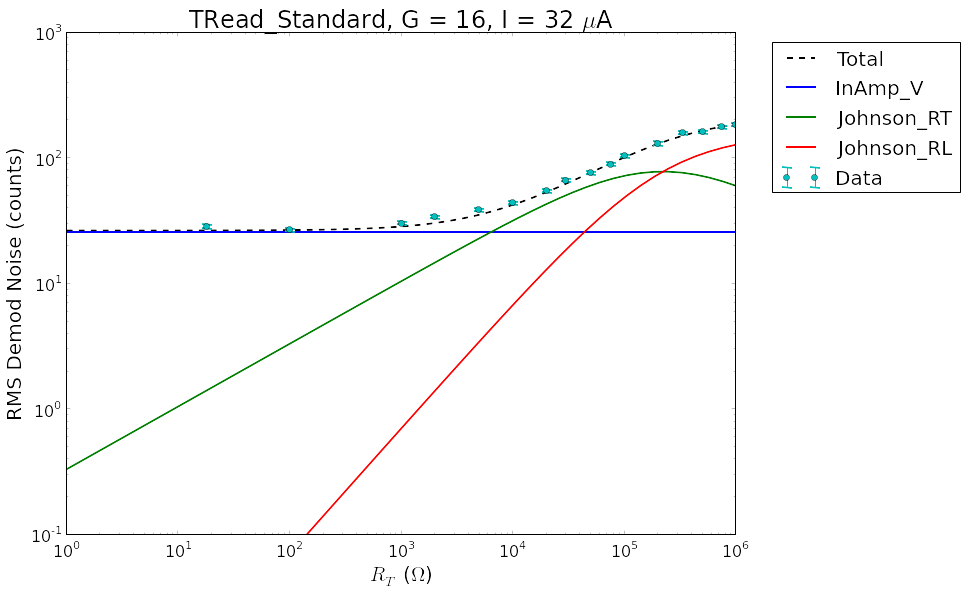

In [2782]:
# Normalized demod (D = demod/2N_SUM) referred noise
# Plot significant components vs R_T
threshhold = 0.5  # Plot threshhold for individual components, i.e. if ever comp/tot > threshhold, plot it
print "1st Index (ADAC) = ", adac_unique
print "2nd Index (Gain) = ", gain_unique
i = 2
j = 4
print "Using: ADAC = {0}, Gain = {1}".format(adac_unique[i], gain_unique[j])
print "Excitation I = {0} nA".format(G_dacs[i]*513.)

ddgs = dDemod_Gs[i][j]
ddgt = dDemod_Gs_tot[i][j]
ddgc = dDemod_Gs_components[i][j]
# vfact = np.sqrt(1.0736*920.)
vfact = np.sqrt(f_filt)  # Use FIR equivalent bandwidth
fig, ax = plt.subplots(figsize=(12, 9), dpi=150)
ax.plot(R_Ts, ddgt*vfact, 'k--', label='Total', linewidth=2)
for k in range(len(ddgs[0].names)):
    name = ddgs[0].names[k]
    value = ddgc[k]
    if np.any(value/ddgt > threshhold):
        ax.plot(R_Ts, ddgt*0 + value*vfact, label=name, linewidth=2)
        
mya = sdata_ag[i, j, :, (1, 5, 9)]  # 1st -> adac, 2nd -> gain, 3rd -> row, 4th -> column
# col 1 = expected resistance, col 5 = Demod (std), col 6 = N_pts
_, caps, _ = ax.errorbar(mya[0], mya[1], yerr=mya[1]/np.sqrt(2*(mya[2] - 1)), fmt='o', label='Data', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(2)
# ax.plot(mya[0], mya[1], 'o', label='Data')
# ax.plot(mya[0], mya[1]*np.sqrt(2), 'o', label='Data rt2')

ax.legend(bbox_to_anchor=(1.35, 1), prop={'size':20})
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$R_T$ ($\Omega$)', fontsize=20)
ax.set_ylabel(r'RMS Demod Noise (counts)', fontsize=20)
ax.set_title(r'TRead_Standard, G = {0}, I = {1} $\mu$A'.format(int(gain_unique[j]),
                                                               int(np.round(G_dacs[i]*513))), fontsize=24)

# ax.set_ylim(ymin=np.min(dV_Gs_tot)*vfact/10.)
ax.set_ylim(ymin=1.e-1)
ax.tick_params(labelsize=16)

1st Index (ADAC) =  [  1021.   2043.   4085.   8171.  16341.]
2nd Index (Gain) =  [  1.   2.   4.   8.  16.]
Using: ADAC = 4085.0, Gain = 16.0
Excitation I = 31.9763946533 nA


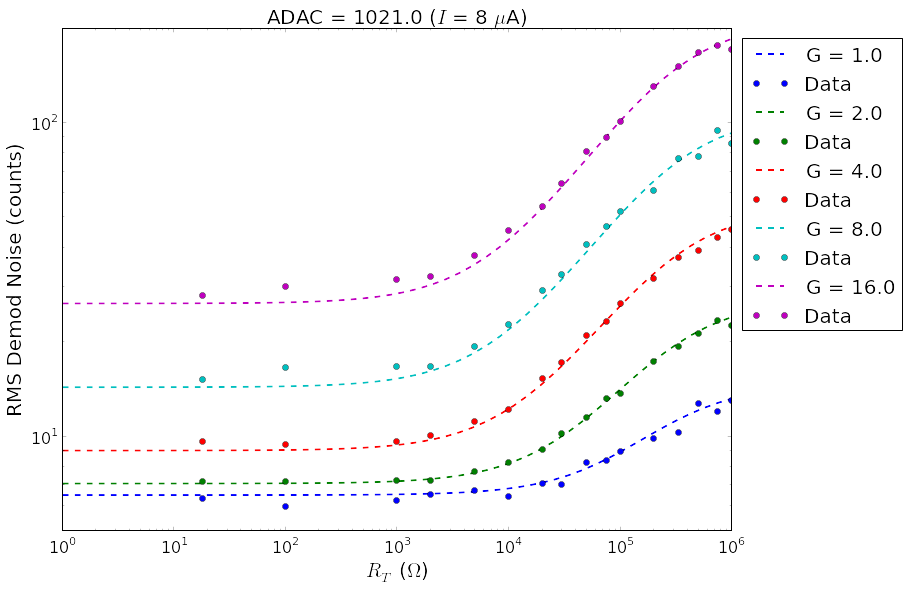

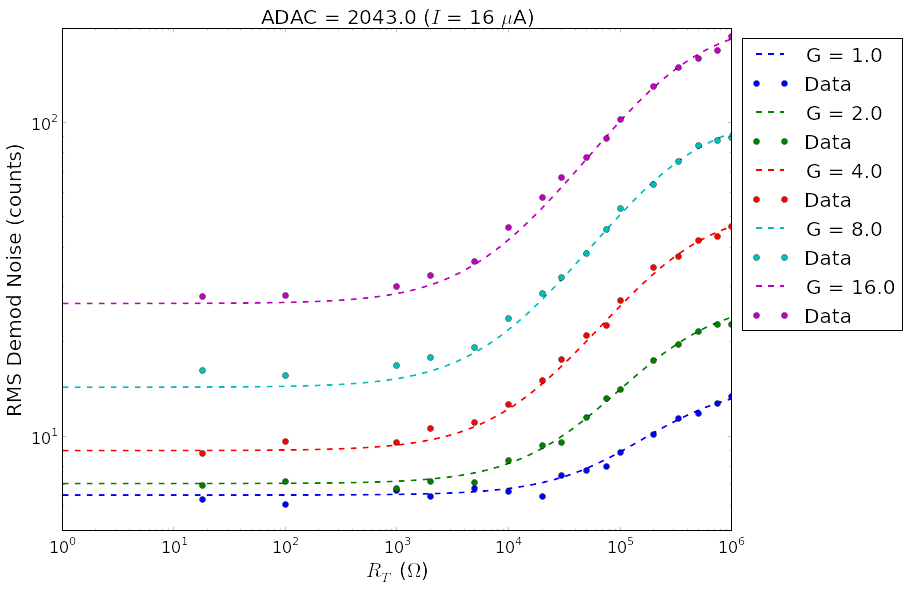

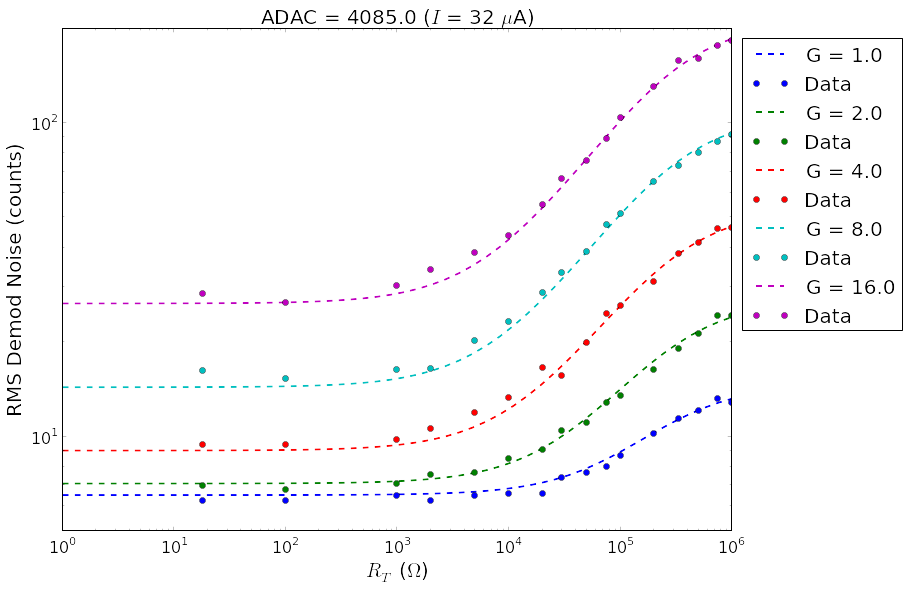

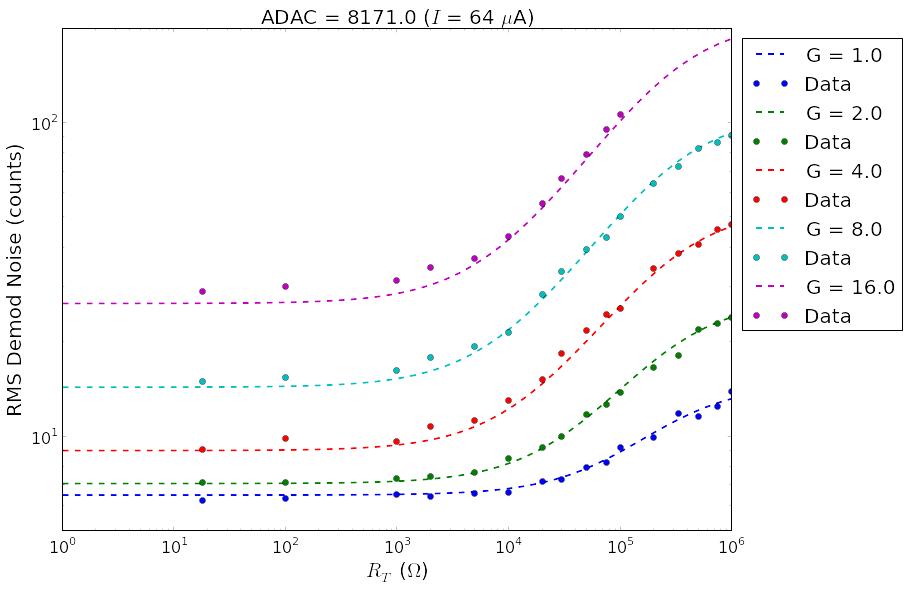

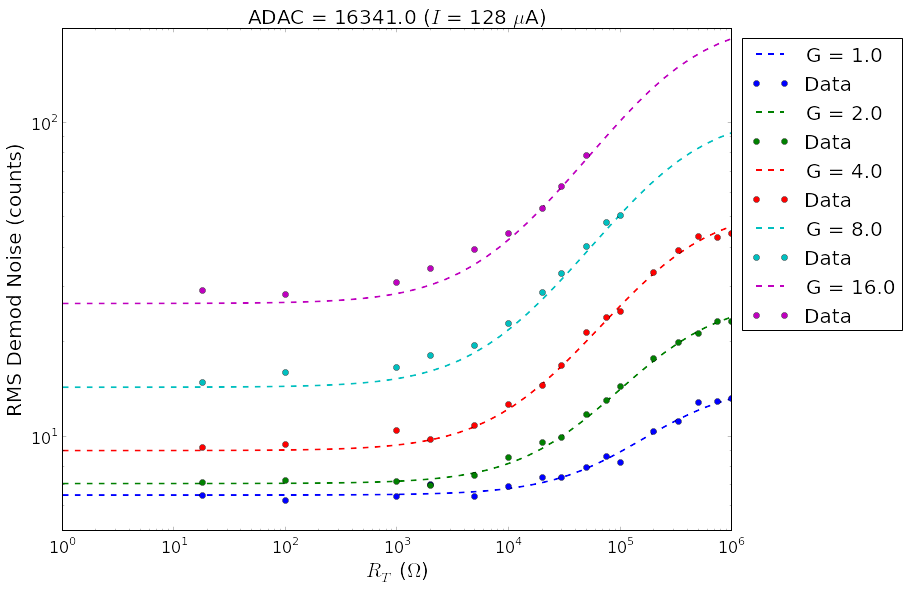

In [2774]:
# Plot significant components vs R_T
threshhold = 0.5  # Plot threshhold for individual components, i.e. if ever comp/tot > threshhold, plot it
print "1st Index (ADAC) = ", adac_unique
print "2nd Index (Gain) = ", gain_unique
i = 2
# j = 0
print "Using: ADAC = {0}, Gain = {1}".format(adac_unique[i], gain_unique[j])
print "Excitation I = {0} nA".format(G_dacs[i]*513.)

for i in range(5):
    fig, ax = plt.subplots(figsize=(12, 9), dpi=150)
    colors = ['b', 'g', 'r', 'c', 'm']
    for j in range(5):
    # ddgs = dDemod_Gs[i][j]
        ddgt = dDemod_Gs_tot[i][j]
        # ddgc = dDemod_Gs_components[i][j]
        # vfact = np.sqrt(1.0736*920.)
        vfact = np.sqrt(f_filt)  # Use FIR equivalent bandwidth
        c = colors[j] + '--'  # dashed line of i-th color
        ax.plot(R_Ts, ddgt*vfact, c, label='G = {0}'.format(gain_unique[j]), linewidth=2)
        # for k in range(len(ddgs[0].names)):
        #     name = ddgs[0].names[k]
        #     value = ddgc[k]
        #     if np.any(value/ddgt > threshhold):
        #         ax.plot(R_Ts, ddgt*0 + value*vfact, label=name, linewidth=2)

        mya = sdata_ag[i, j, :, (1, 5, 9)]  # 1st -> adac, 2nd -> gain, 3rd -> row, 4th -> column
        # col 1 = expected resistance, col 5 = Demod (std)
#         ax.plot(mya[0], mya[1], 'o', label='Data')
#         ax.plot(mya[0], mya[1]*np.sqrt(2), 'o', label='Data rt2')

        # ERROR BARS. Uncomment if want error bars on. Not sure if value is correct...
#         _, caps, _ = ax.errorbar(mya[0], mya[1], yerr=mya[1]/np.sqrt(2*(mya[2] - 1)), fmt='o', label='Data',
#                                  capsize=0)
#         for cap in caps:
#             cap.set_markeredgewidth(2)
        c = colors[j] + 'o'
        ax.plot(mya[0], mya[1], c, label='Data')


    ax.legend(bbox_to_anchor=(1.27, 1), prop={'size':20})
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$R_T$ ($\Omega$)', fontsize=20)
    ax.set_ylabel(r'RMS Demod Noise (counts)', fontsize=20)
    ax.set_title('TRead_Standard', fontsize=24)
    # ax.set_ylim(ymin=np.min(dV_Gs_tot)*vfact/10.)
    ax.set_ylim(ymin=5.e0, ymax=2.e2)
    ax.tick_params(labelsize=16)
    ax.set_title(r'ADAC = {0} ($I$ = {1} $\mu$A)'.format(adac_unique[i], int(np.round(G_dacs[i]*513))), fontsize=20)

In [2015]:
print sdata_ag[2, 3, :, 5]
print sdata_ag[1, 1, :, 5]

[ 16.2005  15.2394  16.4066  20.1575  23.1998  33.1743  47.3723  64.8112
  73.2025  80.0739  87.2456  91.7047  16.3176  28.666   38.7564  51.3809]
[  6.9446   7.1796   7.1788   7.0834   8.3561   9.5557  13.1281  17.3784
  19.6577  21.5568  22.734   22.7583   6.8213   9.3186  11.4368  14.0628]


## TRead_LR

In [1744]:
# TRead_LR
R_45 = 20.e3   # 20 kOhm
R_47 = 20.e3   # 20 kOhm
R_ADG419 = 45. # 45 Ohms for +-15 V, +5V biased
G_ref = 1.  # divider gain
R_FB = 7.e3    # 7 kOhm
G_dac = 1. # 64./2079.
G_pre = 100.
G = 16.
R_P = 100. + 680.     # DG407DJ mux resistance + protection resistor
R_L = 100. + 1.82e3  # protection resistor + bias resistor
R_T = 1.       # 1 Ohm load resistor
R_m1 = 20.e3   # 20 kOhm

In [1745]:
# A
names = ['U14']
stds = [dV_ADR444]
dV_A = Noise(names, stds)
#dV_A

# B
names = ['U15B_V', 'U15B_I', 'U15B_R']
stds = [2*dV_OPA2277, R_45*dI_OPA2277, np.sqrt(4*kB*T_room*(R_45 + R_47))]
dV_B = dV_A.add_stage(1., names, stds)
# dV_B

# C
# names = ['divider_R']
# stds = [np.sqrt(4*kB*T_room*parallel(R_52, R_50 + R_ADG419))]
dV_C = dV_B  # dV_B.add_stage(G_ref, names, stds)
#dV_C

# IN
names = ['U15A_V', 'U15A_I']
stds = [dV_OPA2277, R_ADG419*dI_OPA2277]
dV_in = dV_C.add_stage(1., names, stds)
#dV_in

# DAC
names = ['U18A_V', 'U18A_I', 'DAC_FB_R']
stds = [2*dV_OPA2277, R_FB*dI_OPA2277, np.sqrt(4*kB*T_room*R_FB)]
dV_DAC = dV_in.add_stage(G_dac, names, stds)
#dV_DAC

# Bias circuit
dV_m1 = Noise(['U18B_V', 'U18B_I', 'U18B_R'], [2*dV_OPA2277, R_m1*dI_OPA2277, np.sqrt(4*kB*T_room*2*R_m1)])
dV_RL = Noise(['Johnson_RL'], np.sqrt(4*kB*T_room*R_L))
dV_amp = Noise(['InAmp_V'], dV_AD8221)
dV_ampout = Noise(['InAmp_out'], [dVout_AD8221])
dI_inamp = Noise(['InAmp_I'], [dI_AD8221])

In [1746]:
# ADC Noise back-referenced to ADC input
dV_ADC = Noise(['ADC'], (20.48/65535.) * dD_AD7685/np.sqrt(2000))
#dV_ADC

In [1747]:
R_Ts = np.logspace(-6, 3)  # 1 uOhm -> 1 kOhm
dV_Gs = []
for R_T in R_Ts:
    dV_RT = Noise(['Johnson_RT'], np.sqrt(4*kB*T*R_T))
    g1 = G_pre*(2*R_L/(2*R_L + R_T))
    g2 = G_pre*(R_T/(2*R_L + R_T))
    g3 = np.sqrt(2)*G_pre*(R_P + 0.5*(2*R_L*R_T)/(2*R_L + R_T))
    dV_G = (G*(g2*(np.sqrt(2)*dV_DAC + dV_m1 + np.sqrt(2)*dV_RL) + dV_ampout + G_pre*dV_amp + g1*dV_RT +  g3*dI_inamp)
            + dV_ADC)
    dV_Gs.append(dV_G)

In [1748]:
# Collate individual components for various R_T values
dV_Gs_tot = np.array([dvg.total for dvg in dV_Gs])
dV_Gs_components = []
for i in range(len(dV_Gs[0].names)):
    toadd = np.array([dvg.stds[i] for dvg in dV_Gs])
    dV_Gs_components.append(toadd)

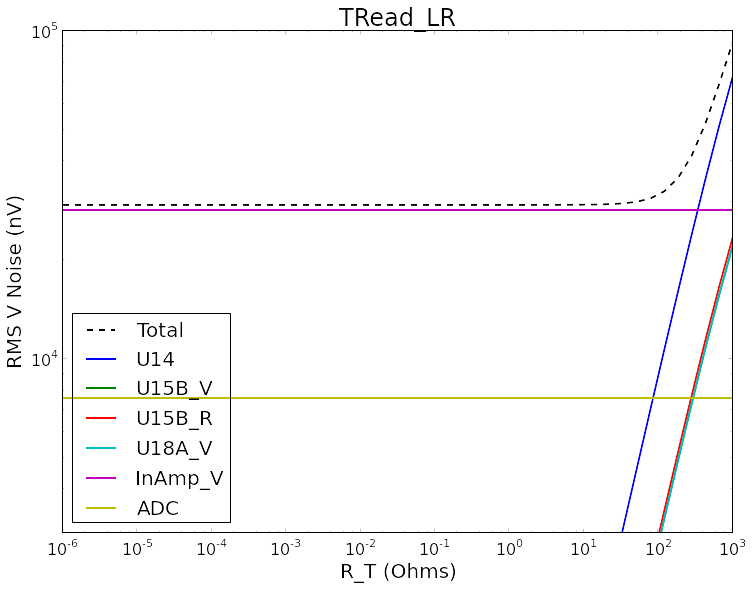

In [1780]:
# Plot significant components vs R_T
threshhold = 0.2  # Plot threshhold for individual components, i.e. if ever comp/tot > threshhold, plot it
vfact = np.sqrt(f_filt)*1.e9  # Use FIR equivalent bandwidth
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(R_Ts, dV_Gs_tot*vfact, 'k--', label='Total', linewidth=2)
for i in range(len(dV_Gs[0].names)):
    name = dV_Gs[0].names[i]
    value = dV_Gs_components[i]
    if np.any(value/dV_Gs_tot > threshhold):
        ax.plot(R_Ts, dV_Gs_tot*0 + value*vfact, label=name, linewidth=2)

ax.legend(loc='lower left', prop={'size':20})
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('R_T (Ohms)', fontsize=20)
ax.set_ylabel(r'RMS V Noise (nV)', fontsize=20)
ax.set_title('TRead_LR', fontsize=24)
ax.set_ylim(ymin=np.min(dV_Gs_tot)*vfact/10.)
ax.tick_params(labelsize=16)

# Filter Transfer Functions

In [1476]:
zfreqs = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3

In [1477]:
N_sum = 66
N_gap = 59
sign = -1
betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
zfreqs_temp = zfreqs + 0.
freqs, hs = scipy.signal.freqz(betas, worN=zfreqs_temp)
freqs *= 2.e3/np.pi
# np.savetxt('imgs/fir66.txt', np.array((freqs, np.abs(hs))).T)

In [1478]:
N_sum2 = 66 + 59
N_gap2 = 0
sign = -1
betas2 = np.array([0.]*N_gap2 + [1.]*N_sum2 + [0.]*N_gap2 + [1.*sign]*N_sum2)/(2*N_sum2)
zfreqs_temp = zfreqs + 0.
freqs2, hs2 = scipy.signal.freqz(betas2, worN=zfreqs_temp)
freqs2 *= 2.e3/np.pi
# np.savetxt('imgs/fir66_nogap.txt', np.array((freqs2, np.abs(hs2))).T)

In [1479]:
N_sum3 = 1
sign = -1
betas3 = np.array([1.]*N_sum3 + [1.*sign]*N_sum3)/(2*N_sum3)
zfreqs_temp = zfreqs + 0.
freqs3, hs3 = scipy.signal.freqz(betas3, worN=zfreqs_temp)
freqs3 *= 2.e3/np.pi
# np.savetxt('imgs/fir1.txt', np.array((freqs3, np.abs(hs3))).T)

In [1480]:
bessel_zpk = scipy.signal.besselap(3)
blti = scipy.signal.lti(*bessel_zpk)

# bessel_sys = scipy.signal.bessel(3, 1.*2*np.pi, analog=True)
zfreqs_temp = zfreqs + 0.
freqs_bessel, hs_bessel = scipy.signal.freqs(blti.num, blti.den, worN=zfreqs_temp)
# freqs_bessel, hs_bessel = scipy.signal.freqs(*bessel_sys, worN=zfreqs_temp)
# omegas, hs_bessel = scipy.signal.freqresp(bessel_sys, w=zfreqs_temp)#n=512)
# freqs_bessel = 2*np.pi*omegas
# freqs_bessel *= 2.e3/np.pi
freqs_bessel *= 920.
# np.savetxt('imgs/antialias.txt', np.array((freqs_bessel, np.abs(hs_bessel))).T)

In [1776]:
print np.sqrt(simps(np.abs(hs[freqs < 920])**2, freqs[freqs < 920]))

5.85184134478
5.50481882563


In [1769]:
print np.sqrt(simps(np.abs(hs[:2560])**2, freqs[:2560]))
print np.sqrt(simps(np.abs(hs[2560:])**2, freqs[2560:]))

4.73964411019
6.86483387012


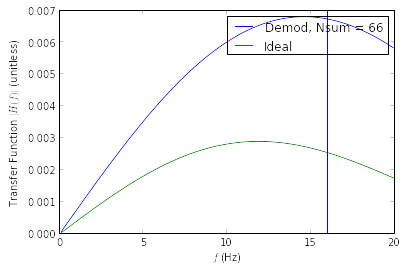

In [1481]:
plt.plot(freqs, np.abs(hs)/(2*N_sum), label='Demod, Nsum = 66')
plt.plot(freqs2, np.abs(hs2)/(2*N_sum2), label='Ideal')
# plt.plot(freqs3, np.abs(hs3), '--', label='Nsum = 1')
#plt.plot(freqs_bessel, np.abs(hs_bessel), label='Bessel')
# plt.xlim(1, 3000)
plt.xlim(0, 20)
# plt.ylim(-0.1, 1.1)
# plt.xscale('log')
plt.legend(loc='upper right')
plt.axvline(60., ls='--', c='y')
plt.axvline(2.e3, ls='--', c='k')
plt.xlabel(r'$f$ (Hz)')
plt.ylabel(r'Transfer Function $|H(f)|$ (unitless)')
# plt.axvline(920.)
plt.axvline(16.)
# plt.axhline(0.5**2)

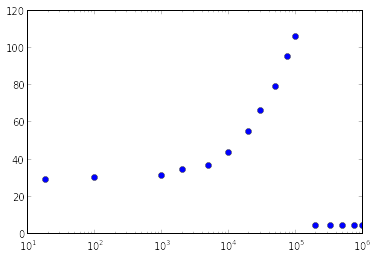

In [1113]:
data = np.loadtxt('imgs/hke_20120103_000_new.txt', skiprows=1, unpack=False)
data_names = ['ch', 'R(nom)', 'ADAC', 'GAIN', 'Demod (avg)', 'Demod (std)', 'NSUM', 'R(avg)', 'R(std)', 'N']
ind = np.lexsort((data[:,3], data[:,2]))
sdata = data[ind]
adac_unique = np.unique(sdata[:,2])
gain_unique = np.unique(sdata[:,3])
sdata_a = [sdata[sdata[:, 2] == a] for a in adac_unique]
sdata_ag = np.array([[s[s[:,3] == g] for g in gain_unique] for s in sdata_a])  # list of list of 2D numpy array
                                                                               # 1st index = adac, 2nd index = gain
mya = sdata_ag[3, 4, :, (1, 5)]
plt.plot(mya[0], mya[1], 'o')
plt.xscale('log')


[18, 100, 2000, 4990, 10000, 30000, 75000, 200000, 332000, 499000, 750000, 1000000]
[ 28.8842  29.887   34.3817  36.7109  43.283   66.1625  95.2535   4.2487
   4.374    4.3835   4.4513   4.2554]


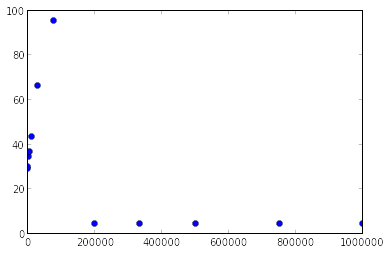

In [1043]:
data_adac8171 = data.T[3::5]
data_adac8171_g16 = data_adac8171[4::5]
Rs_adac8171_g16 = data_adac8171_g16.T[1][:-4]
dDemods_adac8171_g16 = data_adac8171_g16.T[5][:-4]
plt.plot(Rs_adac8171_g16, dDemods_adac8171_g16, 'o')
print [int(r) for r in Rs_adac8171_g16]
print dDemods_adac8171_g16

w_3dB =  1.00000296558
w_eq = 1.15359429258 * w_3dB


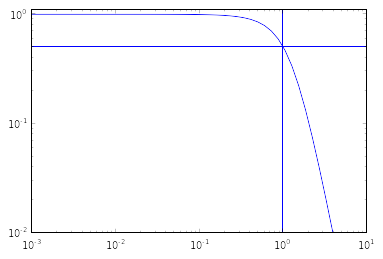

In [846]:
# hs_bw3 = lambda s: 1./(1. + 2.*s + 2*s**2 + 1.*s**3)
hs_bw3 = lambda s: 1./(1. + 1.36165*s + .61803*s**2 + 0*s**3)
# hs_bw3 = lambda s: 1./(1. + 1.75567*s + 1.23295*s**2 + .36078*s**3)
abshs2_bw3 = lambda w: np.abs(hs_bw3(1j*w))**2
rf_func = lambda w: abshs2_bw3(w) - 1./2

w3dB = brentq(rf_func, 0, 10)
print "w_3dB = ", w3dB

ws = np.logspace(-3, 1)
hs = abshs2_bw3(ws)

plt.plot(ws, hs)
plt.xscale('log')
plt.yscale('log')
plt.axvline(w3dB)
plt.axhline(0.5)
plt.ylim(ymin=1.e-2, ymax=1.1)

print "w_eq = {0} * w_3dB".format(quad(abshs2_bw3, 0, np.infty)[0]/w3dB)
# quad(hs_bessel3_2, 0, np.infty)[0]/w3dB

In [812]:
hs_bessel3 = lambda w: 225./(w**6 + 6*w**4 + 45*w**2 + 225)
rf_func = lambda w: hs_bessel3(2*w) - 1./2
hs_bessel3_2 = lambda w: hs_bessel3(2*w)

w3dB = brentq(rf_func, 0, 1000)
print w3dB

# quad(hs_bessel3, 0, np.infty)[0]/w3dB
quad(hs_bessel3_2, 0, np.infty)[0]/w3dB

0.877836184341


1.0736374427136244

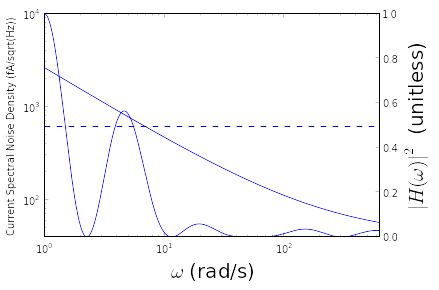

In [493]:
# AD8221 current spectral noise density and digital filter
ws = np.logspace(0, np.log(1000.*2*np.pi), 10000)
fig, ax = plt.subplots()
ax2 = plt.twinx(ax)
fig, ax, ax2
ax.plot(ws, dI_func(ws)*1.e15)
ax2.plot(ws, filt_func(ws))
ax.set_yscale('log')
# ax2.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1, 100*2*np.pi])
ax.set_ylim(ymin=40.)
ax.set_xlabel(r'$\omega$ (rad/s)', fontsize=20)
ax.set_ylabel('Current Spectral Noise Density (fA/sqrt(Hz))')
ax2.set_ylabel(r'$|H(\omega)|^2$ (unitless)', fontsize=20)
ax.axhline(dI_AD8221*1.e15, ls='--')

5.5927352240915083

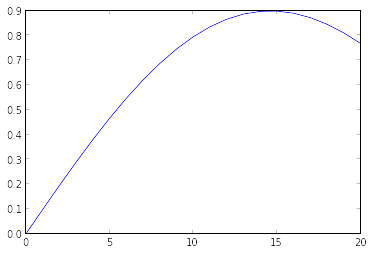

In [1398]:
Fbetas = np.fft.fft(betas, n=int(f_s))
# DTFTbetas_func = lambda w: Fbetas.dot(np.exp(1j*np.arange(len(Fbetas))*w))
fs = np.arange(f_s)
plt.plot(fs, np.abs(Fbetas))
plt.xlim(xmax=20)
np.sum(np.abs(Fbetas[15::16]))
# ws = np.linspace(0, 4000*2*np.pi, 5000)
# DTFTbetas = np.array([DTFTbetas_func(w) for w in ws])
# plt.plot(ws, np.abs(DTFTbetas))
# plt.xlim(0, 1000)

[ 6.72952622  2.91689957  8.80849369  4.25454323  8.56116762  0.61940066
  4.16288258  2.22953916  3.55166568  5.78781801  4.57565513  0.86210771
  8.14439956  2.78175863  5.88639043  9.38303398]
[-6.72952622 -2.91689957 -8.80849369 -4.25454323 -8.56116762 -0.61940066
 -4.16288258 -2.22953916 -3.55166568 -5.78781801 -4.57565513 -0.86210771
 -8.14439956 -2.78175863 -5.88639043 -9.38303398]
[-6.72952622 -2.91689957 -8.80849369 -4.25454323 -8.56116762 -0.61940066
 -4.16288258 -2.22953916 -3.55166568 -5.78781801 -4.57565513 -0.86210771
 -8.14439956 -2.78175863 -5.88639043 -9.30796971]


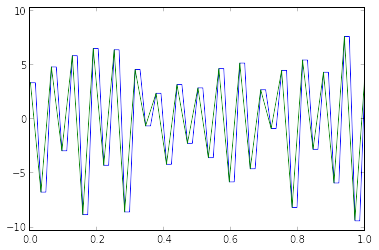

In [1460]:
tmin, tmax = 0, 1
f_s = 4000.
n_ch = 16.
ts = np.linspace(tmin, tmax, (tmax-tmin)*f_s)
vs = scipy.signal.square(ts*(2*np.pi*16))
values = 10.24*np.random.rand(16)
# values = 4*np.ones(16) # 10.24*np.arange(16)/15.
vs = vs*np.array([[v]*int((tmax-tmin)*f_s/n_ch) for v in values]).flatten()

N_sum = 66
N_gap = 59
sign = -1
betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)

N_sum2 = 66 + 59
N_gap2 = 0
sign = -1
betas2 = np.array([0.]*N_gap2 + [1.]*N_sum2 + [0.]*N_gap2 + [1.*sign]*N_sum2)/(2*N_sum2)

vs1 = scipy.signal.convolve(vs, betas, mode='same')#/(2*N_sum)
vs2 = scipy.signal.convolve(vs, betas2, mode='same')#/(2*N_sum)

# plt.plot(ts, vs)
plt.plot(ts, vs1)
plt.plot(ts, vs2)
plt.ylim(-10.3, 10.3)
print values
print vs1[f_s/(2*n_ch)::int(f_s/n_ch)]
print vs2[f_s/(2*n_ch)::int(f_s/n_ch)]
# np.where(vs2 == values[0])

## Simulating Square wave vs Sine Wave Excitation

### Square Wave

In [2384]:
N_sum = 66
N_gap = 59
sign = -1
betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs, hs = scipy.signal.freqz(betas, worN=zfreqs_temp)
freqs *= 2.e3/np.pi
# np.savetxt('imgs/fir66.txt', np.array((freqs, np.abs(hs))).T)

In [2385]:
N_sum2 = 66 + 59
N_gap2 = 0
sign = -1
betas2 = np.array([0.]*N_gap2 + [1.]*N_sum2 + [0.]*N_gap2 + [1.*sign]*N_sum2)/(2*N_sum2)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs2, hs2 = scipy.signal.freqz(betas2, worN=zfreqs_temp)
freqs2 *= 2.e3/np.pi
# np.savetxt('imgs/fir66_nogap.txt', np.array((freqs2, np.abs(hs2))).T)

In [2386]:
f_SUM

30.3030303030303

\int |H(f)|^2 df (Demod) =  103.52504424
\int |H(f)|^2 df (Ideal) =  69.054633596
\int |H(f)|^2 df (Random) =  154.235159753


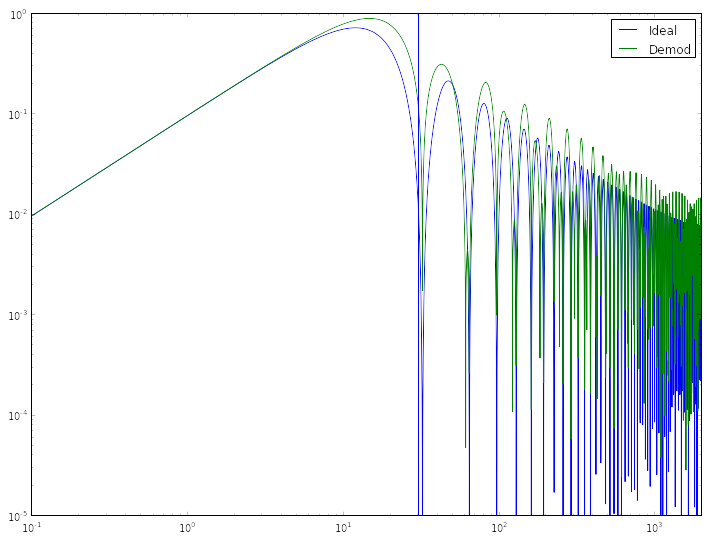

In [2389]:
N_sum = 66
N_gap = 59
sign = -1
kernel_toy = np.random.rand(N_sum + N_gap)
kernel_sum = kernel_toy.sum()
betas_toy = np.array([kernel_toy, sign*kernel_toy]).flatten()/(2*kernel_sum)
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_toy, hs_toy = scipy.signal.freqz(betas_toy, worN=zfreqs_temp)
freqs_toy *= 2.e3/np.pi

plt.figure(figsize=(12, 9))
# plt.plot(freqs_toy, np.abs(hs_toy), label='Random')
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymin=1.e-5)
plt.plot(freqs2, np.abs(hs2), label='Ideal')
plt.plot(freqs, np.abs(hs), label='Demod')
plt.xlim(xmax=2000.)
# plt.xlim(xmax=2*f_SUM)
plt.legend()
plt.axvline(f_SUM)
print "\int |H(f)|^2 df (Demod) = ", simps(np.abs(hs), freqs)
print "\int |H(f)|^2 df (Ideal) = ", simps(np.abs(hs2), freqs2)
print "\int |H(f)|^2 df (Random) = ", simps(np.abs(hs_toy), freqs_toy)

In [1504]:
tmin, tmax = 0, 1
f_s = 4000.
n_ch = 16.
ts = np.linspace(tmin, tmax, (tmax-tmin)*f_s)
vs = scipy.signal.square(ts*(2*np.pi*16))
values = 10.24*np.random.rand(16)
# values = 4*np.ones(16) # 10.24*np.arange(16)/15.
vs = vs*np.array([[v]*int((tmax-tmin)*f_s/n_ch) for v in values]).flatten()

# N_sum = 66
# N_gap = 59
# sign = -1
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)

# N_sum2 = 66 + 59
# N_gap2 = 0
# sign = -1
# betas2 = np.array([0.]*N_gap2 + [1.]*N_sum2 + [0.]*N_gap2 + [1.*sign]*N_sum2)/(2*N_sum2)

# vs1 = scipy.signal.convolve(vs, betas, mode='same')#/(2*N_sum)
# vs2 = scipy.signal.convolve(vs, betas2, mode='same')#/(2*N_sum)
vs_toy = scipy.signal.convolve(vs, betas_toy, mode='same')#/(2*N_sum)

# plt.plot(ts, vs)
# plt.plot(ts, vs1)
# plt.plot(ts, vs2)
# plt.ylim(-10.3, 10.3)
print values
# print vs1[f_s/(2*n_ch)::int(f_s/n_ch)]
# print vs2[f_s/(2*n_ch)::int(f_s/n_ch)]
print vs_toy[f_s/(2*n_ch)::int(f_s/n_ch)]
# np.where(vs2 == values[0])

[  1.13206586   2.15235552  10.1581456    8.00736775   8.15184197
   6.66123076   7.8860784    6.56380091   5.44070104   3.84764943
   0.37764506   4.56369646   4.25908518   9.01942012   6.03887999
   4.70494783]
[ -1.13206586  -2.15235552 -10.1581456   -8.00736775  -8.15184197
  -6.66123076  -7.8860784   -6.56380091  -5.44070104  -3.84764943
  -0.37764506  -4.56369646  -4.25908518  -9.01942012  -6.03887999
  -4.68493016]


### Sine Wave

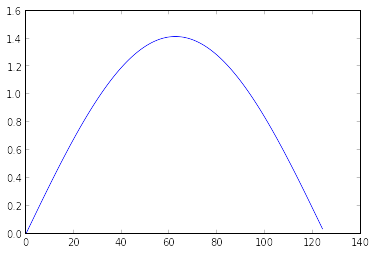

In [2439]:
N_sum = 66
N_gap = 59
amp = np.sqrt(2)
carrier = amp*np.sin(np.arange(N_sum + N_gap)*np.pi/(N_sum + N_gap))
plt.plot(carrier)

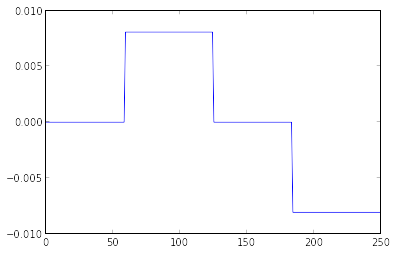

In [2440]:
N_sum = 66
N_gap = 59
sign = -1
betas = np.array([0.]*N_gap + [1.]*N_sum)
betas_sum = np.dot(carrier, betas)
betas = np.array([betas, sign*betas]).flatten()/(2*betas_sum)

zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs, hs = scipy.signal.freqz(betas, worN=zfreqs_temp)
freqs *= 2.e3/np.pi
# np.savetxt('imgs/fir66.txt', np.array((freqs, np.abs(hs))).T)
plt.plot(betas)

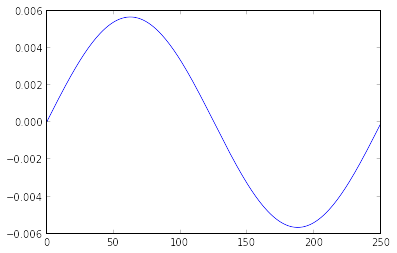

In [2441]:
# N_sum = 66
# N_gap = 59
sign = -1
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
betas_sq = carrier
betas_sq_sum = np.dot(carrier, betas_sq)
betas_sq = np.array([betas_sq, sign*betas_sq]).flatten()/(2*betas_sq_sum)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_sq, hs_sq = scipy.signal.freqz(betas_sq, worN=zfreqs_temp)
freqs_sq *= 2.e3/np.pi
# np.savetxt('imgs/fir66.txt', np.array((freqs, np.abs(hs))).T)
plt.plot(betas_sq)

In [2644]:
import numpy as np

n_ch = 16          # Number of channels to measure
T_frame = 1.       # Frame period
N_hp = 125         # Number of ticks per half-period

T0 = T_frame/n_ch  # Single-channel period, assuming 1 second total period
w0 = 2*np.pi/T0    # Single-channel angular frequency
T60 = 1./60.       # 60 Hz period
w60 = 2*np.pi/T60  # 60 Hz angular frequency

amp = np.sqrt(2)   # A = sqrt(2) gives time-averaged power amplitude of 1

f1 = lambda t: -np.sin(w0*t)**2 * amp
f2 = lambda t: np.sin(w0*t)*np.sin(w60*t)
f3 = lambda t: np.sin(2*w0*t)*np.sin(w60*t)

result1 = quad(f1, 0, T0)[0]
result2 = quad(f2, 0, T0)[0]
result3 = quad(f3, 0, T0)[0]

print result1, result2, result3
k0 = 1./result1
k1 = -result2/(result1*result3)
print "k0 = ", k0
print "k1 = ", k1

ct = lambda t: np.sin(w0*t)
ht = lambda t: k0*np.sin(w0*t) + k1*np.sin(2*w0*t)
ht0 = lambda t: k0*np.sin(w0*t)

ts = np.linspace(0, T0)
cts = ct(ts)
hts = ht(ts)
ht0s = ht0(ts)

tosave = np.array([ts, cts, hts, ht0s]).T

print hts.max(), ht0s.max()
print hts.min(), ht0s.min()
# plt.plot(ts, cts)
# plt.plot(ts, hts)
# plt.plot(ts, ht0s)

-0.0441941738242 -0.000761506904746 -0.00197708003841
k0 =  -22.627416998
k1 =  8.71534482458
27.2095362298 22.6157913977
-27.2095362298 -22.6157913977


In [2552]:
import numpy as np

n_ch = 16          # Number of channels to measure
T_frame = 1.       # Frame period
N_hp = 125         # Number of ticks per half-period

T0 = T_frame/n_ch  # Single-channel period, assuming 1 second total period
w0 = 2*np.pi/T0    # Single-channel angular frequency
T60 = 1./60.       # 60 Hz period
w60 = 2*np.pi/T60  # 60 Hz angular frequency

amp = np.sqrt(2)   # A = sqrt(2) gives time-averaged power amplitude of 1

f1 = lambda t: -np.sin(w0*t)**2 * amp
f2 = lambda t: np.sin(w0*t)*np.sin(w60*t)
f3 = lambda t: np.sin(2*w0*t)*np.sin(w60*t)

result1 = quad(f1, 0, T0)[0]
result2 = quad(f2, 0, T0)[0]
result3 = quad(f3, 0, T0)[0]

print result1, result2, result3
k0 = 1./result1
k1 = -result2/(result1*result3)
print "k0 = ", k0
print "k1 = ", k1

# N_sum = 66
# N_gap = 59
sign = -1
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
betas_60 = (k0*np.sin(np.arange(2*(N_sum + N_gap))*np.pi/(N_sum + N_gap)) 
            + k1*np.sin(2*np.arange(2*(N_sum + N_gap))*np.pi/(N_sum + N_gap)))

carrier2 = amp*np.sin(np.arange(2*(N_sum + N_gap))*np.pi/(N_sum + N_gap))
betas_60_sum = np.dot(carrier2, betas_60)
betas_60 = betas_60/betas_60_sum
betas_60_max = np.abs(betas_60).max()
gain1 = 32767/betas_60_max
betas_60 = gain1*betas_60

Fmax = betas_60_max
print Fmax
GAIN = 2*125*Fmax*16/(32767*k0)
SUM_TICKS = 125
GAIN2 = 2*betas_60_max/(32767*k0*T0)
print GAIN
print GAIN2
print GAIN2*SUM_TICKS


gain = gain1

carrier = (65535*np.sin(np.arange(N_hp)*np.pi/N_hp)).astype('int')

-0.0441941738242 -0.000761506904746 -0.00197708003841
k0 =  -22.627416998
k1 =  8.71534482458
0.00680281382687
-3.67009169906e-05
-2.93607335925e-07
-3.67009169906e-05


In [2549]:
T0, 1./16

(0.0625, 0.0625)

In [2547]:
print 3.67009169906e-05
print 125*0.0011744293437

3.67009169906e-05
0.146803667962


In [2539]:
tmin, tmax = 0, 1
f_s = 4000.
n_ch = 16.
ts = np.linspace(tmin, tmax, (tmax-tmin)*f_s)
gain2 = 65535.
vs = amp*np.sin(ts*(2*np.pi*16))*gain2
values = 10.24*np.random.rand(16)
# values = 4*np.ones(16) # 10.24*np.arange(16)/15.
vs = vs*np.array([[v]*int((tmax-tmin)*f_s/n_ch) for v in values]).flatten()

vs_60 = scipy.signal.convolve(vs, betas_60, mode='same')#/(2*N_sum)

print values[:2]
print vs_60[f_s/(2*n_ch)::int(f_s/n_ch)][:2]/(gain*gain2)

[ 7.35140587  6.57376438]
[-7.34925044 -6.57208035]


[ 0.99968419]
\int |H(f)|^2 df (60 Hz Sine Rejection, hs_60) =  49.53970827


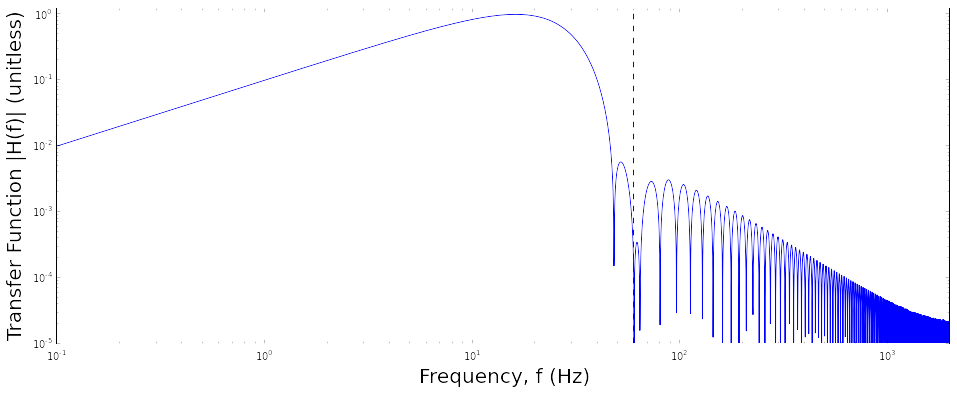

In [2729]:
N_chop = N_sum + N_gap
N_tot = 2*N_chop
ns = np.arange(N_tot, dtype='float')
w0d = 2*np.pi/N_tot

T0 = 1./n_ch
w0 = 2*np.pi/T0
T60 = 1./60.
w60 = 2*np.pi/T60
dT = T0/N_tot

f1 = lambda t: -np.sin(w0*t)**2
f2 = lambda t: np.sin(w0*t)*np.sin(w60*t)
f3 = lambda t: np.sin(2*w0*t)*np.sin(w60*t)

result1 = quad(f1, 0, T0)[0]
result2 = quad(f2, 0, T0)[0]
result3 = quad(f3, 0, T0)[0]

k0 = 1./result1
k1 = -result2/(result1*result3)

betas_60 = (k0*np.sin(w0d*ns) + k1*np.sin(2*w0d*ns)) * dT
carrier2 = np.sin(w0d*ns)

print np.convolve(betas_60, carrier2, mode="valid")# * dT

zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_60, hs_60 = scipy.signal.freqz(betas_60, worN=zfreqs_temp)
freqs_60 *= 2.e3/np.pi

plt.plot(freqs_60, np.abs(hs_60))
plt.xlim(xmax=2000.)
plt.ylim(ymin=1.e-5)
plt.yscale('log')
plt.legend(loc='lower left')
plt.xscale('log')
plt.xlabel('Frequency, f (Hz)', fontsize=20)
plt.ylabel('Transfer Function |H(f)| (unitless)', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16,6)
plt.axvline(60., ls='--')

print "\int |H(f)|^2 df (60 Hz Sine Rejection, hs_60) = ", simps(np.abs(hs_60), freqs_60)

[ 1.]
\int |H(f)|^2 df (Square Wave, hs_sq) =  103.52504424


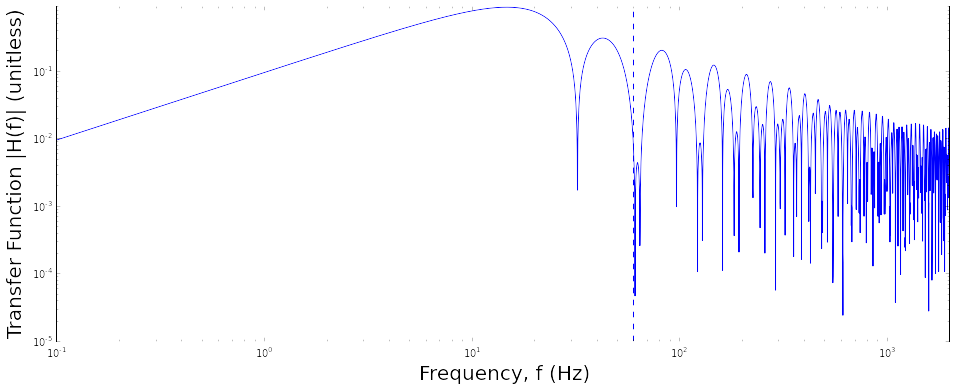

In [2728]:
N_sum = 66
N_gap = 59
sign = -1
carrier_sq = np.array([1.]*N_gap + [1.]*N_sum + [1.*sign]*N_gap + [1.*sign]*N_sum)
betas_sq = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(-2*N_sum)

# betas_60 = (k0*np.sin(w0d*ns) + k1*np.sin(2*w0d*ns)) * dT
# carrier2 = np.sin(w0d*ns)

print np.convolve(betas_sq, carrier_sq, mode="valid")# * dT

zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_sq, hs_sq = scipy.signal.freqz(betas_sq, worN=zfreqs_temp)
freqs_sq *= 2.e3/np.pi

plt.plot(freqs_sq, np.abs(hs_sq))
plt.xlim(xmax=2000.)
plt.ylim(ymin=1.e-5)
plt.yscale('log')
plt.legend(loc='lower left')
plt.xscale('log')
plt.xlabel('Frequency, f (Hz)', fontsize=20)
plt.ylabel('Transfer Function |H(f)| (unitless)', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16,6)
plt.axvline(60., ls='--')

print "\int |H(f)|^2 df (Square Wave, hs_sq) = ", simps(np.abs(hs_sq), freqs_sq)

[Constant Amplitude] (Std Square)/(Std Sine)  0.908583704482
[Constant Power Dissipation] rt(2)*(Std Square)/(Std Sine)  1.28493139743


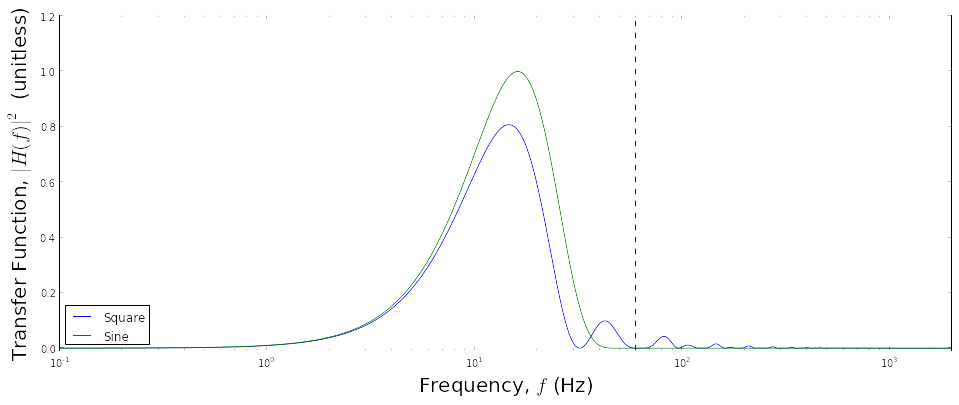

In [2755]:
plt.plot(freqs_sq, np.abs(hs_sq)**2, label='Square')
plt.plot(freqs_60, np.abs(hs_60)**2, label='Sine')
plt.legend()
plt.xlim(xmax=2000.)
plt.ylim(ymin=-0.01)#1.e-10)
# plt.yscale('log')
plt.legend(loc='lower left')
plt.xscale('log')
plt.xlabel(r'Frequency, $f$ (Hz)', fontsize=20)
plt.ylabel(r'Transfer Function, $|H(f)|^2$ (unitless)', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16,6)
plt.axvline(60., ls='--')

Var_sq = simps(np.abs(hs_sq)**2, freqs_sq)
Var_60 = simps(np.abs(hs_60)**2, freqs_60)


print "[Constant Amplitude] (Std Square)/(Std Sine) ", np.sqrt(Var_sq/Var_60)
print "[Constant Power Dissipation] rt(2)*(Std Square)/(Std Sine) ", np.sqrt(2)*np.sqrt(Var_sq/Var_60)

# print "[Constant Amplitude] (Sq Power)/(Sine Power) ", simps(np.abs(hs_sq), freqs_sq)/simps(np.abs(hs_60), freqs_60)
# print "[Constant Power Dissipation] rt(2)*(Sq Power)/(Sine Power) ", (simps(np.abs(hs_sq), freqs_sq)/
#                                                                 simps(np.abs(hs_60/np.sqrt(2)), freqs_60))

In [2745]:
print Var_sq, Var_60
print (k0**2 + k1**2)*T0/2 + 2*np.abs(k0*k1) * 4*T0/(3*np.pi)
print 1./(2*t_SUM)

30.6448263933 37.1216505797
57.6715062705
30.303030303


-0.0441941738242 -0.000761506904746 -0.00197708003841
k0 =  -22.627416998
k1 =  8.71534482458


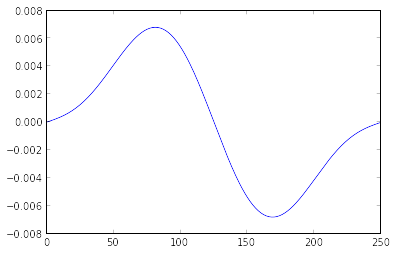

In [2662]:
T0 = 1./n_ch
w0 = 2*np.pi/T0
T60 = 1./60.
w60 = 2*np.pi/T60

f1 = lambda t: -np.sin(w0*t)**2 * amp
f2 = lambda t: np.sin(w0*t)*np.sin(w60*t)
f3 = lambda t: np.sin(2*w0*t)*np.sin(w60*t)

result1 = quad(f1, 0, T0)[0]
result2 = quad(f2, 0, T0)[0]
result3 = quad(f3, 0, T0)[0]

print result1, result2, result3
k0 = 1./result1
k1 = -result2/(result1*result3)
print "k0 = ", k0
print "k1 = ", k1

# N_sum = 66
# N_gap = 59
sign = -1
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
betas_60 = (k0*np.sin(np.arange(2*(N_sum + N_gap))*np.pi/(N_sum + N_gap)) 
            + k1*np.sin(2*np.arange(2*(N_sum + N_gap))*np.pi/(N_sum + N_gap)))

carrier2 = amp*np.sin(np.arange(2*(N_sum + N_gap))*np.pi/(N_sum + N_gap))
betas_60_sum = np.dot(carrier2, betas_60)
betas_60 = betas_60/betas_60_sum
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_60, hs_60 = scipy.signal.freqz(betas_60, worN=zfreqs_temp)
freqs_60 *= 2.e3/np.pi
# np.savetxt('imgs/fir66.txt', np.array((freqs, np.abs(hs))).T)
plt.plot(betas_60)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


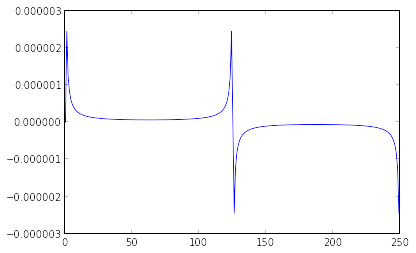

In [2516]:
# N_sum = 66
# N_gap = 59
sign = -1
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
betas_is = 1./(carrier)
betas_is[betas_is == np.inf] = 0
betas_is_sum = np.dot(carrier, betas_is)
betas_is = np.array([betas_is, sign*betas_is]).flatten()/(2*betas_is_sum)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_is, hs_is = scipy.signal.freqz(betas_is, worN=zfreqs_temp)
freqs_is *= 2.e3/np.pi
# np.savetxt('imgs/fir66.txt', np.array((freqs, np.abs(hs))).T)
plt.plot(betas_is)

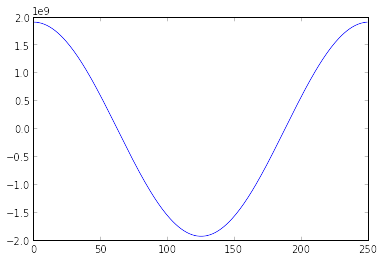

In [2517]:
# N_sum = 66
# N_gap = 59
sign = -1
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
betas_cos = np.cos(np.arange(N_sum + N_gap)*np.pi/(N_sum + N_gap))
betas_cos_sum = np.dot(carrier, betas_cos)
betas_cos = np.array([betas_cos, sign*betas_cos]).flatten()/(2*betas_cos_sum)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_cos, hs_cos = scipy.signal.freqz(betas_cos, worN=zfreqs_temp)
freqs_cos *= 2.e3/np.pi
# np.savetxt('imgs/fir66.txt', np.array((freqs, np.abs(hs))).T)
plt.plot(betas_cos)

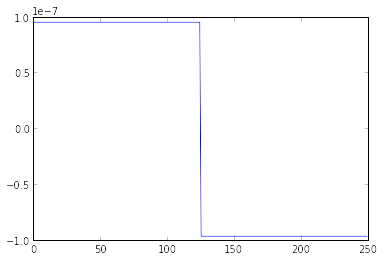

In [2518]:
N_sum2 = 66 + 59
N_gap2 = 0
sign = -1
betas2 = np.array([0.]*N_gap2 + [1.]*N_sum2)
betas2_sum = np.dot(carrier, betas2)
betas2 = np.array([betas2, sign*betas2]).flatten()/(2*betas2_sum)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs2, hs2 = scipy.signal.freqz(betas2, worN=zfreqs_temp)
freqs2 *= 2.e3/np.pi
# np.savetxt('imgs/fir66_nogap.txt', np.array((freqs2, np.abs(hs2))).T)
plt.plot(betas2)

In [2519]:
f0 = lambda t: np.sin(w0*t)*np.sin(w0*t)
quad(f0, 0, T0)

(0.031249999999999997, 2.2937003140975454e-11)

\int |H(f)|^2 df (Ideal, hs2) =  0.00165526683259
\int |H(f)|^2 df (Random, hs_toy) =  0.00397790276464
\int |H(f)|^2 df (Sine, hs_sq) =  32.7610785648
\int |H(f)|^2 df (60 Hz Reject, hs_60) =  35.0298636558


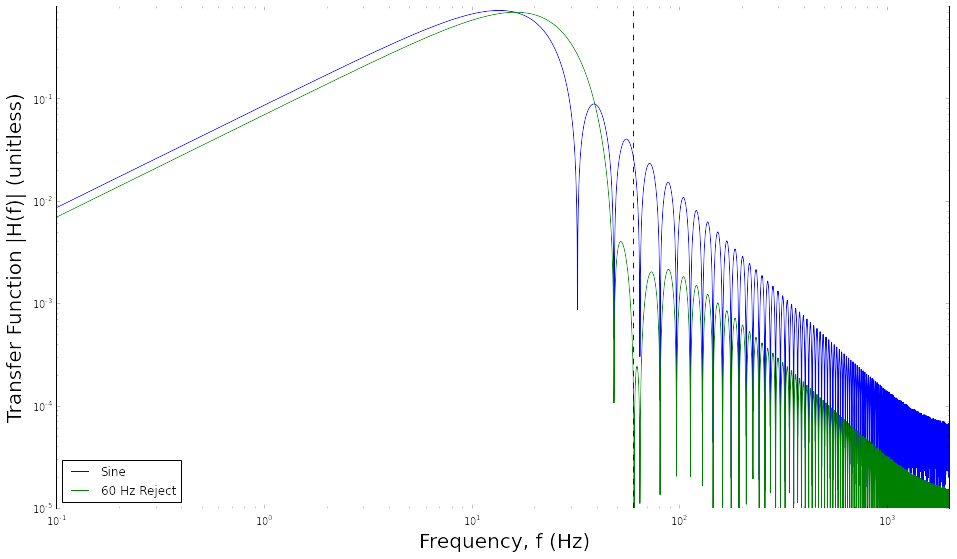

In [2520]:
N_sum = 66
N_gap = 59
sign = -1
kernel_toy = np.random.rand(N_sum + N_gap)
# carrier = np.sin(np.arange(len(kernel_toy))*np.pi/len(kernel_toy))
kernel_sum = np.dot(carrier, kernel_toy)
# kernel_sum = kernel_toy.sum()
betas_toy = np.array([kernel_toy, sign*kernel_toy]).flatten()/(2*kernel_sum)
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)
zfreqs_temp = np.logspace(-1., np.log10(4.e3), 5120)*np.pi/2.e3 # zfreqs + 0.
freqs_toy, hs_toy = scipy.signal.freqz(betas_toy, worN=zfreqs_temp)
freqs_toy *= 2.e3/np.pi

# plt.plot(freqs_toy, np.abs(hs_toy), label='Random')
plt.plot(freqs_sq, np.abs(hs_sq), label='Sine')
# plt.plot(freqs_cos, np.abs(hs_cos), label='Cos')
plt.plot(freqs_60, np.abs(hs_60), label='60 Hz Reject')
# plt.plot(freqs_is, np.abs(hs_is), label='Inv Sine')
# plt.plot(freqs2, np.abs(hs2), label='Ideal')
# plt.plot(freqs, np.abs(hs), label='Demod')
plt.xlim(xmax=2000.)
plt.ylim(ymin=1.e-5)
plt.yscale('log')
plt.legend(loc='lower left')
plt.xscale('log')
plt.xlabel('Frequency, f (Hz)', fontsize=20)
plt.ylabel('Transfer Function |H(f)| (unitless)', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16,9)
plt.axvline(60., ls='--')

# print "\int |H(f)|^2 df (Demod, hs1) = ", simps(np.abs(hs), freqs)
print "\int |H(f)|^2 df (Ideal, hs2) = ", simps(np.abs(hs2), freqs2)
print "\int |H(f)|^2 df (Random, hs_toy) = ", simps(np.abs(hs_toy), freqs_toy)
print "\int |H(f)|^2 df (Sine, hs_sq) = ", simps(np.abs(hs_sq), freqs_sq)
# print "\int |H(f)|^2 df (Cos, hs_cos) = ", simps(np.abs(hs_cos), freqs_cos)
print "\int |H(f)|^2 df (60 Hz Reject, hs_60) = ", simps(np.abs(hs_60), freqs_60)
# print "\int |H(f)|^2 df (Inv Sine, hs_is) = ", simps(np.abs(hs_is), freqs_is)

[ 8.87607876  2.65345074]
[ 35493.90513615  10611.08396374]
[ -1.91497930e-04  -5.72481518e-05]
[ -1.91576607e-04  -5.72701607e-05]
[-8.87233673 -2.65243032]
[-8.87347628 -2.65277099]


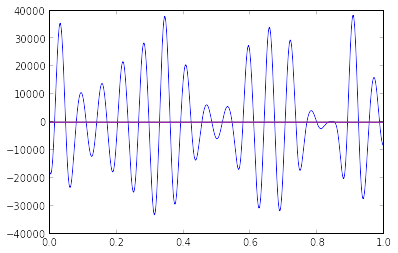

In [2523]:
tmin, tmax = 0, 1
f_s = 4000.
n_ch = 16.
ts = np.linspace(tmin, tmax, (tmax-tmin)*f_s)
vs = amp*np.sin(ts*(2*np.pi*16))
values = 10.24*np.random.rand(16)
# values = 4*np.ones(16) # 10.24*np.arange(16)/15.
vs = vs*np.array([[v]*int((tmax-tmin)*f_s/n_ch) for v in values]).flatten()

# N_sum = 66
# N_gap = 59
# sign = -1
# betas = np.array([0.]*N_gap + [1.]*N_sum + [0.]*N_gap + [1.*sign]*N_sum)/(2*N_sum)

# N_sum2 = 66 + 59
# N_gap2 = 0
# sign = -1
# betas2 = np.array([0.]*N_gap2 + [1.]*N_sum2 + [0.]*N_gap2 + [1.*sign]*N_sum2)/(2*N_sum2)

vs1 = scipy.signal.convolve(vs, betas, mode='same')#/(2*N_sum)
vs2 = scipy.signal.convolve(vs, betas2, mode='same')#/(2*N_sum)
vs_toy = scipy.signal.convolve(vs, betas_toy, mode='same')#/(2*N_sum)
vs_sq = scipy.signal.convolve(vs, betas_sq, mode='same')#/(2*N_sum)
vs_60 = scipy.signal.convolve(vs, betas_60, mode='same')#/(2*N_sum)

# plt.plot(ts, vs)
plt.plot(ts, vs1)
plt.plot(ts, vs2)
plt.plot(ts, vs_toy)
plt.plot(ts, vs_sq)
plt.plot(ts, vs_60)
# plt.ylim(-10.3, 10.3)
print values[:2]
print vs1[f_s/(2*n_ch)::int(f_s/n_ch)][:2]
print vs2[f_s/(2*n_ch)::int(f_s/n_ch)][:2]
print vs_toy[f_s/(2*n_ch)::int(f_s/n_ch)][:2]
print vs_sq[f_s/(2*n_ch)::int(f_s/n_ch)][:2]
print vs_60[f_s/(2*n_ch)::int(f_s/n_ch)][:2]
# np.where(vs2 == values[0])

In [2435]:
print 49.53970827/103.52504424
print 1 - np.sqrt(49.53970827/103.52504424)

0.478528733155
0.308242287246


Analysis of Square vs Sine wave excitation
-----------

In [2555]:
# Add path to bitbucket/eswitzer/piper_stack.git:piperlib/bp_boards module
import sys
sys.path.append('/Users/jlazear/bitbucket/piper_stack/piperlib/bp_boards')

# Import tread
from tread import TRead

In [2601]:
f = open('/Users/jlazear/tread_test_data.txt', 'r')

In [2602]:
f.seek(0)

alllines = f.readlines()

brd1lines = alllines[0:-1:2]
brd3lines = alllines[1::2]

In [2604]:
TRead.parse_tread_string(brd1lines[0])

{'brd01:addr:ch0': 1,
 'brd01:demod:ch0': 17.16798947042333,
 'brd01:demod:ch1': 104.98812861949094,
 'brd01:demod:ch10': 882661.0956615774,
 'brd01:demod:ch11': 1202687.0205347615,
 'brd01:demod:ch12': 1034.0964552191238,
 'brd01:demod:ch13': 20764.255113590294,
 'brd01:demod:ch14': 52007.994251813056,
 'brd01:demod:ch15': 104933.60656172957,
 'brd01:demod:ch2': 2069.2099602739395,
 'brd01:demod:ch3': 5180.717149782128,
 'brd01:demod:ch4': 10390.040636286747,
 'brd01:demod:ch5': 31252.91206979019,
 'brd01:demod:ch6': 78709.95663027493,
 'brd01:demod:ch7': 212561.53285125442,
 'brd01:demod:ch8': 358463.440885996,
 'brd01:demod:ch9': 556465.1690940524,
 'brd01:frame:ch0': 89,
 'brd01:mode:ch0': 'standard',
 'brd01:nsum:ch0': 66,
 'brd01:raw_adac:ch0': 4085,
 'brd01:raw_adac:ch1': 4085,
 'brd01:raw_adac:ch10': 4085,
 'brd01:raw_adac:ch11': 4085,
 'brd01:raw_adac:ch12': 4085,
 'brd01:raw_adac:ch13': 4085,
 'brd01:raw_adac:ch14': 4085,
 'brd01:raw_adac:ch15': 4085,
 'brd01:raw_adac:ch2': 4

In [2603]:
check1 = [line[2] for line in brd1lines]
check3 = [line[2] for line in brd3lines]

for i, number in enumerate(check1):
    if number != '1':
        print "Failed check 1 ({0}, {1})!".format(i, number)

for i in check3:
    if i != '3':
        print "Failed check 3 ({0})!".format(i)

In [2606]:
range(12, 16)

[12, 13, 14, 15]

In [2622]:
# board 1 = sine wave, board 3 = square wave
data1 = []
for line in brd1lines:
    temp = TRead.parse_tread_string(line)
    toret = [temp['brd01:demod:ch{0}'.format(i)] for i in range(12, 16)]
    data1.append(toret)
    
data3 = []
for line in brd3lines:
    temp = TRead.parse_tread_string(line)
    toret = [temp['brd03:demod:ch{0}'.format(i)] for i in range(12, 16)]
    data3.append(toret)
    
data1 = np.array(data1)
data3 = np.array(data3)

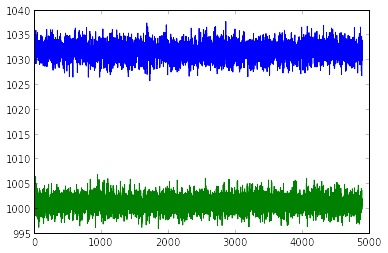

In [2625]:
plt.plot(data1[:, 0])
plt.plot(data3[:, 0])

In [2632]:
data3[0]

array([   1001.4941756 ,   20039.71133667,   49981.0281368 ,
        100223.9866908 ])

In [2636]:
tablestr = "{0:^15} {1:^20} {2:^20} {3:^15}"

print tablestr.format("RESISTANCE", "SINE", "SQUARE", "RATIO")
print tablestr.format('-'*15, '-'*20, '-'*20, '-'*15)
Rs = [1, 20, 50, 100]
for i in range(data1.shape[1]):
    label = str(Rs[i]) + 'k'
    sine = data1[:, i].std()
    sq = data3[:, i].std()
    print tablestr.format(label, sine, sq, sine/sq)
    
#print "sine wave, 1k std = ", data1[:, 0].std()
#print "square wave, 1k std = ", data3[:, 0].std()

  RESISTANCE            SINE                SQUARE             RATIO     
--------------- -------------------- -------------------- ---------------
      1k           1.67346987946         1.5875943719      1.05409159233 
      20k           3.5521572668        3.21491575624      1.10489901948 
      50k          6.82513556983        5.47036675075      1.24765593987 
     100k          13.3024600931        9.99343484775      1.33111990979 


# Junk for reals

(0.0, 25000000.0)

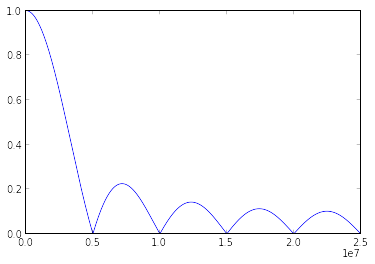

In [2154]:
N_sum = 10
betas_mce = np.array([1.]*N_sum)/(N_sum)
zfreqs_temp = zfreqs + 0.
freqs_mce, hs_mce = scipy.signal.freqz(betas, worN=zfreqs_temp)
freqs_mce *= 25.e6/np.pi

plt.plot(freqs_mce, np.abs(hs_mce))
plt.xlim(xmax=25.e6)

(1000.0, 25000000.0)

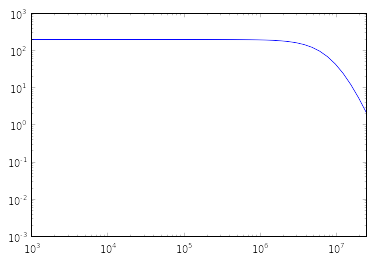

In [2197]:
poles_ubcamp = np.array([9.7, 9.7, 15.2, 15.2, 7.2])*1.e6
gain_ubcamp = 203.
hs_ubcamp = np.vectorize(lambda f: 203./np.sqrt(np.prod([(1. + (f/p)**2) for p in poles_ubcamp])))

fs = np.logspace(3, 8)
# hs_values = [hs_ubcamp(f) for f in fs]
hs_values = hs_ubcamp(fs)
plt.plot(fs, hs_values)
plt.xscale('log')
plt.yscale('log')
plt.xlim(xmax=25.e6)

In [2217]:
N_sum/f_MCE

2e-07

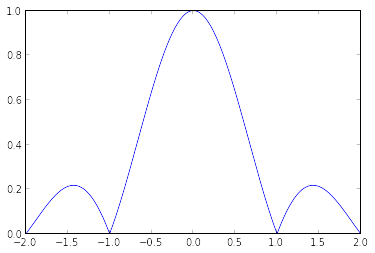

In [2252]:
xs = np.linspace(-2, 2, 500)
plt.plot(xs, np.abs(np.sinc(xs)))

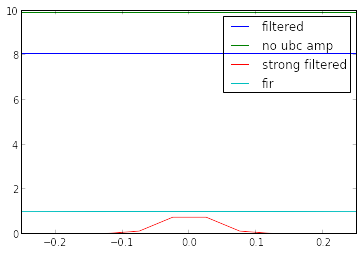

In [2282]:
fs = np.linspace(-25.e6, 25.e6, 1000)
foffset = 0.5e6
f_MCE = 50.e6
N_sum = 10
t_s = N_sum/f_MCE

#h_fir = lambda f: np.abs(np.sin(np.pi*f*N_sum/(2*f_MCE))/(np.pi*f*N_sum/(2*f_MCE)))
#h_fir = lambda f: np.abs(np.sin(np.pi*f*N_sum/f_MCE)/(np.pi*f*N_sum/f_MCE))
h_fir = lambda f: np.abs(np.sinc(t_s*f))

# aliased = np.array([hs_ubcamp(fs + n*foffset)**2/hs_ubcamp(0)**2 * h_fir(fs + n*foffset)**2 for n in range(-10, 10)])
aliased2 = np.array([hs_ubcamp(fs + n*foffset)**2/hs_ubcamp(0)**2 * h_fir(fs + n*foffset)**2 for n in range(-100, 100)])
aliased3 = np.array([h_fir(fs + n*foffset)**2 for n in range(-100, 100)])
aliased4 = np.array([hs_ubcamp(100*fs + 100*n*foffset)**2/hs_ubcamp(0)**2 * h_fir(fs + n*foffset)**2 for n in range(-100, 100)])
#plt.plot(fs, hs_ubcamp(fs))
# for a in aliased:
#     plt.plot(fs, a)
# plt.plot(fs/1.e6, (np.sum(aliased, axis=0)))
# plt.plot(fs/1.e6, (np.sum(aliased2, axis=0)), label='filtered')
# plt.plot(fs/1.e6, (np.sum(aliased3, axis=0)), label='no ubc amp')
# plt.plot(fs/1.e6, (np.sum(aliased4, axis=0)), label='strong filtered')
#plt.plot(fs/1.e6, (np.sum(aliased2, axis=0) - np.sum(aliased, axis=0)))
plt.plot(fs/1.e6, h_fir(fs), label='fir')
plt.xlim(-0.25, 0.25)
# plt.yscale('log')
#plt.ylim(.9, 1.1)
#(np.sum(aliased2, axis=0) - np.sum(aliased, axis=0))
plt.legend()

(0, 22.163518337716589)

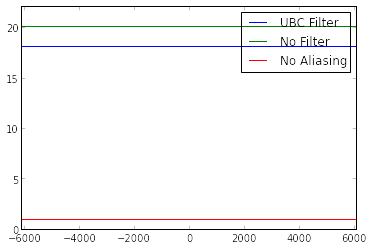

In [2374]:
# Define UBC Amplifier response
poles_ubcamp = np.array([9.7, 9.7, 15.2, 15.2, 7.2])*1.e6
gain_ubcamp = 203.
hs_ubcamp = np.vectorize(lambda f: 203./np.sqrt(np.prod([(1. + (f/p)**2) 
                                                         for p in poles_ubcamp])))

# Define row dwell FIR
f_MCE = 50.e6
sample_num = 10
sample_dly = 90
row_len = sample_num + sample_dly
num_row = 41
t_s = sample_num/f_MCE

h_fir = lambda f: np.abs(np.sinc(t_s*f))

# fs = np.logspace(3, np.log10(25.e6), 200)
fs = np.linspace(0, 25.e6, 200)
fs[0] = 1.e3
hs_fir = h_fir(fs)

# plt.plot(fs, hs_fir, 'o')
# plt.xscale('log')
# plt.xlim(xmax=25.e6)

## Define aliased FIR ##
f_max = f_MCE/(2*num_row*row_len)
foffset = 2*f_max
fs = np.linspace(-f_max, f_max, 200)

# Find how many instances we need to count for aliasing
bfunc = lambda f, c: hs_ubcamp(f)**2/hs_ubcamp(0)**2 - c
fc = brentq(bfunc, 1.e6, 100.e6, args=(.01))
n_alias = int(fc/f_max)

# Compute aliased FIR power
aliased = np.array([hs_ubcamp(fs + n*foffset)**2/hs_ubcamp(0)**2 * h_fir(fs + n*foffset)**2
                    for n in range(-n_alias, n_alias)])
aliased = np.sqrt(np.sum(aliased, axis=0))
aliased2 = np.array([h_fir(fs + n*foffset)**2 for n in range(-n_alias*2, n_alias*2)])
aliased2 = np.sqrt(np.sum(aliased2, axis=0))
aliased3 = h_fir(fs)**2
aliased3 = np.sqrt(aliased3)

plt.plot(fs, aliased, label='UBC Filter')
plt.plot(fs, aliased2, label='No Filter')
plt.plot(fs, aliased3, label='No Aliasing')
plt.xlim(xmin=-f_max, xmax=f_max)
plt.legend()
plt.ylim(ymin=0, ymax=1.1*np.mean(aliased2))

(0, 22.163518337716589)

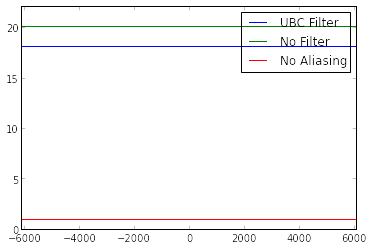

In [2394]:
# Define UBC Amplifier response
poles_ubcamp = np.array([9.7, 9.7, 15.2, 15.2, 7.2])*1.e6
gain_ubcamp = 203.
hs_ubcamp = np.vectorize(lambda f: 203./np.sqrt(np.prod([(1. + (f/p)**2) 
                                                         for p in poles_ubcamp])))

# Define row dwell FIR
f_MCE = 5.e6
sample_num = 1
sample_dly = 9
row_len = sample_num + sample_dly
num_row = 41
t_s = sample_num/f_MCE

h_fir = lambda f: np.abs(np.sinc(t_s*f))

# fs = np.logspace(3, np.log10(25.e6), 200)
fs = np.linspace(0, 25.e6, 200)
fs[0] = 1.e3
hs_fir = h_fir(fs)

# plt.plot(fs, hs_fir, 'o')
# plt.xscale('log')
# plt.xlim(xmax=25.e6)

## Define aliased FIR ##
f_max = f_MCE/(2*num_row*row_len)
foffset = 2*f_max
fs = np.linspace(-f_max, f_max, 200)

# Find how many instances we need to count for aliasing
bfunc = lambda f, c: hs_ubcamp(f)**2/hs_ubcamp(0)**2 - c
fc = brentq(bfunc, 1.e6, 100.e6, args=(.01))
n_alias = int(fc/f_max)

# Compute aliased FIR power
aliased = np.array([hs_ubcamp(fs + n*foffset)**2/hs_ubcamp(0)**2 * h_fir(fs + n*foffset)**2
                    for n in range(-n_alias, n_alias)])
aliased = np.sqrt(np.sum(aliased, axis=0))
aliased2 = np.array([h_fir(fs + n*foffset)**2 for n in range(-n_alias*2, n_alias*2)])
aliased2 = np.sqrt(np.sum(aliased2, axis=0))
aliased3 = h_fir(fs)**2
aliased3 = np.sqrt(aliased3)

plt.plot(fs, aliased, label='UBC Filter')
plt.plot(fs, aliased2, label='No Filter')
plt.plot(fs, aliased3, label='No Aliasing')
plt.xlim(xmin=-f_max, xmax=f_max)
plt.legend()
plt.ylim(ymin=0, ymax=1.1*np.mean(aliased2))

In [2375]:
print f_max
print 3.26e6/f_max
print np.mean(aliased)
print np.mean(aliased2)

6097.56097561
534.64
18.1908029825
20.1486530343


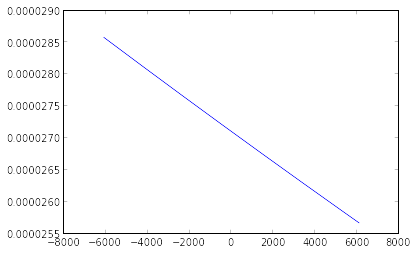

In [2333]:
n = 800
f_max = f_MCE/(2*num_row*row_len)
fs2 = np.linspace(-f_max, f_max, 200)
aliased3 = hs_ubcamp(fs2 + n*foffset)**2/hs_ubcamp(0)**2 * h_fir(fs2 + n*foffset)**2
# plt.plot(fs2, h_fir(fs2)**2*hs_ubcamp(fs2)**2/hs_ubcamp(0)**2)
plt.plot(fs2, aliased3)
# plt.ylim(0, 1.01)

(0.0, 1.1)

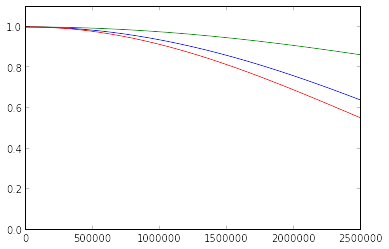

In [2214]:
# Define 
N_sum = 10
betas_mce = np.array([1.]*N_sum)/(N_sum)
zfreqs_temp = zfreqs + 0.
freqs_mce, hs_mce = scipy.signal.freqz(betas_mce, worN=zfreqs_temp)
freqs_mce *= 25.e6/np.pi

hs_values = hs_ubcamp(freqs_mce)

plt.plot(freqs_mce, np.abs(hs_mce))
plt.plot(freqs_mce, hs_values/hs_values[0])
plt.plot(freqs_mce, hs_values/hs_values[0] * np.abs(hs_mce))
plt.xlim(xmax=2.5e6)
plt.ylim(ymax=1.1)

(0.55000000000000004, 1.1)

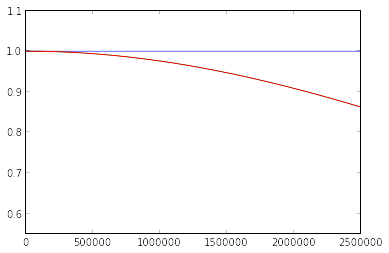

In [2200]:
N_sum = 1
betas_mce = np.array([1.]*N_sum)/(N_sum)
zfreqs_temp = zfreqs + 0.
freqs_mce, hs_mce = scipy.signal.freqz(betas_mce, worN=zfreqs_temp)
freqs_mce *= 2.5e6/np.pi

hs_values = hs_ubcamp(freqs_mce)

plt.plot(freqs_mce, np.abs(hs_mce))
plt.plot(freqs_mce, hs_values/hs_values[0])
plt.plot(freqs_mce, hs_values/hs_values[0] * np.abs(hs_mce))
plt.xlim(xmax=2.5e6)
plt.ylim(ymax=1.1)